In [184]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
# from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from collections import Counter
from skimage import color as scolor
from PIL import Image
from datetime import datetime
from dotenv import load_dotenv

In [228]:
load_dotenv()
folder_path = os.getenv('path_goya_pics')
df_lines_circles = os.getenv('path_lines_dataset_goya')
# folder_path = './data/paintings'
# folder_path

In [229]:
files = os.listdir(folder_path)
target_files = []
for f in files:
    if ('.jpg' in f) or ('.jpeg' in f):
        target_files.append(os.path.join(folder_path, f))

print('Количество картин в датасете:', len(target_files))

Количество картин в датасете: 243


### Смотрим, сколько картин художник написал за каждый год жизни

In [187]:
dates = []
for i in target_files:
    date = i.split('/')[-1].split('_')[0]
    dates.append(date)

In [188]:
from collections import Counter

year_counts = dict(Counter(dates))
del year_counts['yyyy']

In [189]:
df = pd.DataFrame(dates, columns=['year'])
df.shape

(243, 1)

In [190]:
df['unknown'] = df.year.apply(lambda x: True if x == 'yyyy' else False)
df.unknown.value_counts()

unknown
False    240
True       3
Name: count, dtype: int64

In [191]:
result = df.groupby('year', as_index=False).agg({'unknown': 'count'}).rename(columns={'unknown': 'count'})

In [192]:
mask = df[df.unknown == False].year.to_list()
mask.sort()
# mask

In [193]:
mask.extend(['yyyy' for _ in range(4)])
len(mask)

244

In [194]:
sns.set_theme(style="white")

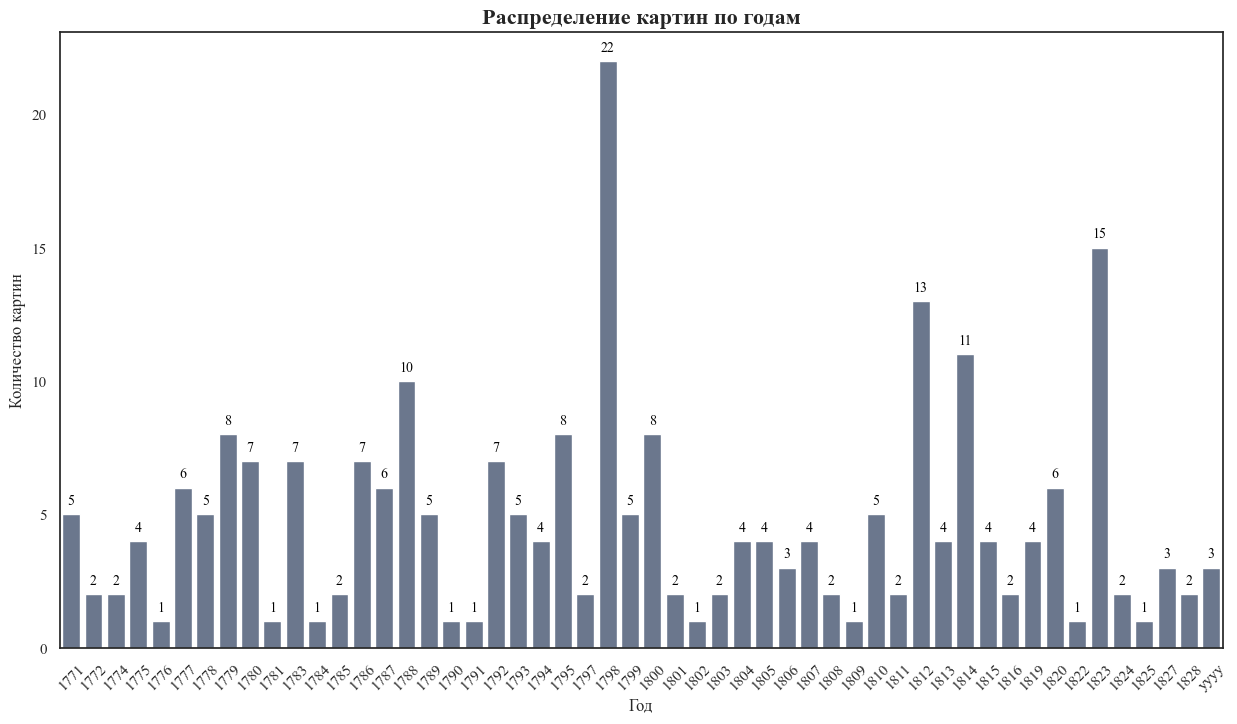

In [195]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.figure(figsize=(15, 8))

color_hex = '#{:02x}{:02x}{:02x}'.format(102, 118, 146)
bar_plot = sns.barplot(data=result, x='year', y='count', color=color_hex, order=mask)

plt.title('Распределение картин по годам', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Год', fontdict={'fontsize': 12})
plt.ylabel('Количество картин', fontdict={'fontsize': 12})
plt.xticks(rotation=45)


for p in bar_plot.patches:
    bar_plot.annotate(format(int(p.get_height())), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, color='black', 
                        xytext=(0, 5), textcoords='offset points')

plt.show()

In [196]:
df_counts = pd.DataFrame(year_counts.items(), columns=['year', 'count'])
df_counts.head()

,year,count
0,1799,5
1,1775,4
2,1812,13
3,1787,6
4,1814,11


### Смотрим 7 самых часто встречающихся диапазонов цветов на всех картинках

In [197]:
def rgb_to_lab(rgb_array):

    rgb_array = rgb_array / 255.0  # normalizing RGB
    lab_array = scolor.rgb2lab(rgb_array)
    
    return lab_array

In [198]:
def get_pixels_from_folder(folder_path, rgb_lab):

    all_pixels = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((128, 128))
                pixels = np.array(img)
                all_pixels.append(pixels.reshape(-1, 3))

            except Exception as e:
                print(f"Can't open {filename}: {e}")

    # combine all pixels into one vector
    if all_pixels:
        rgb_vector = np.vstack(all_pixels) 
        if rgb_lab == 'RGB':
            return rgb_vector
        elif rgb_lab == 'LAB':
            lab_vector = rgb_to_lab(rgb_vector)
            return lab_vector
    else:
        return np.array([])

In [199]:
# finding the n most common color ranges in the !RGB vector! and sort them by frequency
def find_most_common_colors(vector, rgb_lab, classifier_type, n_colors=7):
    
    if vector.size == 0:
        print("Vector is empty")
        return []

    if classifier_type == 'KMeans':
        results_cluster = KMeans(n_clusters=n_colors)
        results_cluster.fit(vector)
        colors = results_cluster.cluster_centers_
    elif classifier_type == 'GM':
        results_cluster = GaussianMixture(n_components=n_colors, random_state=42)
        results_cluster.fit(vector)
        colors = results_cluster.means_
        labels = results_cluster.predict(vector) # 'GaussianMixture' object has no attribute 'labels_'
    elif classifier_type == 'GMM':
        gmm = BayesianGaussianMixture(n_components=n_colors, random_state=42)
        gmm.fit(vector)
        colors = gmm.means_
        labels = gmm.predict(vector)
        
        
    # colors = results_cluster.cluster_centers_
    
    if rgb_lab == 'LAB':
        rgb_colors = scolor.lab2rgb(colors.reshape(1, -1, 3)).reshape(-1, 3) * 255 # LAB to RGB
    elif rgb_lab == 'RGB':
        rgb_colors = colors        
    rgb_colors = np.clip(rgb_colors, 0, 255).astype(int)

    # counting pixels of each cluster by color
    if classifier_type == 'KMeans':
        labels = results_cluster.labels_
        label_counts = Counter(labels)
    elif classifier_type == 'GM':
        label_counts = Counter(labels)
    elif classifier_type == 'GMM':
        # labels = gmm.predict(lab_vector)
        label_counts = Counter(labels)

    sorted_colors = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_rgb_colors = rgb_colors[[color[0] for color in sorted_colors]]

    return sorted_rgb_colors

In [200]:
def plot_colors(colors):
    plt.figure(figsize=(15, 6))
    plt.imshow([colors], aspect='auto')
    
    for i, color in enumerate(colors):
        plt.text(i, 0, str(i+1), ha='center', va='center', fontsize=20, color='white')
    
    plt.axis('off')
    plt.show()

##### Без перевода из RGB в Lab с помощью KMeans:

In [201]:
pixels_vector = get_pixels_from_folder(folder_path, rgb_lab='RGB')

In [202]:
most_common_colors_nolab = find_most_common_colors(pixels_vector, rgb_lab='RGB', classifier_type='KMeans', n_colors=7)

In [203]:
most_common_colors_nolab

array([[ 52,  43,  35],
       [ 19,  16,  15],
       [ 91,  75,  58],
       [172, 163, 140],
       [146, 109,  70],
       [118, 124, 117],
       [213, 208, 191]])

Семь самых распространенных цветов (RGB):
Цвет 1: [52 43 35]
Цвет 2: [19 16 15]
Цвет 3: [91 75 58]
Цвет 4: [172 163 140]
Цвет 5: [146 109  70]
Цвет 6: [118 124 117]
Цвет 7: [213 208 191]


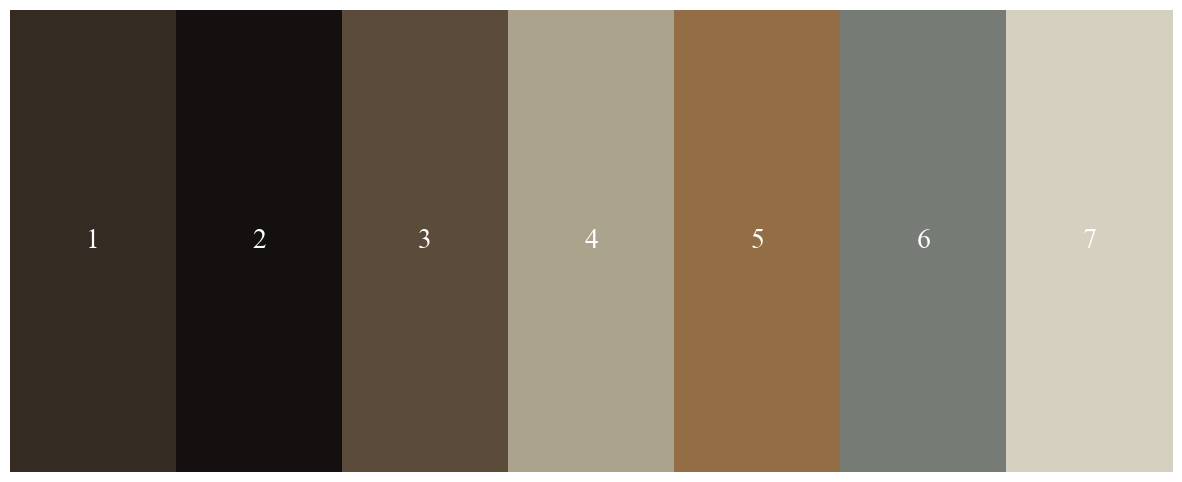

In [204]:
print("Семь самых распространенных цветов (RGB):")
c = 1
for i in most_common_colors_nolab:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors_nolab)

##### С переводом из RGB в LAB с помощью KMeans:

In [205]:
pixels_vector = get_pixels_from_folder(folder_path, rgb_lab='LAB')

In [206]:
most_common_colors = find_most_common_colors(pixels_vector, rgb_lab='LAB', classifier_type='KMeans', n_colors=7)

Семь самых распространенных цветов (RGB -> LAB -> RGB):
Цвет 1: [24 21 20]
Цвет 2: [58 49 40]
Цвет 3: [98 86 65]
Цвет 4: [127 135 134]
Цвет 5: [164 137  91]
Цвет 6: [201 194 176]
Цвет 7: [130  69  42]


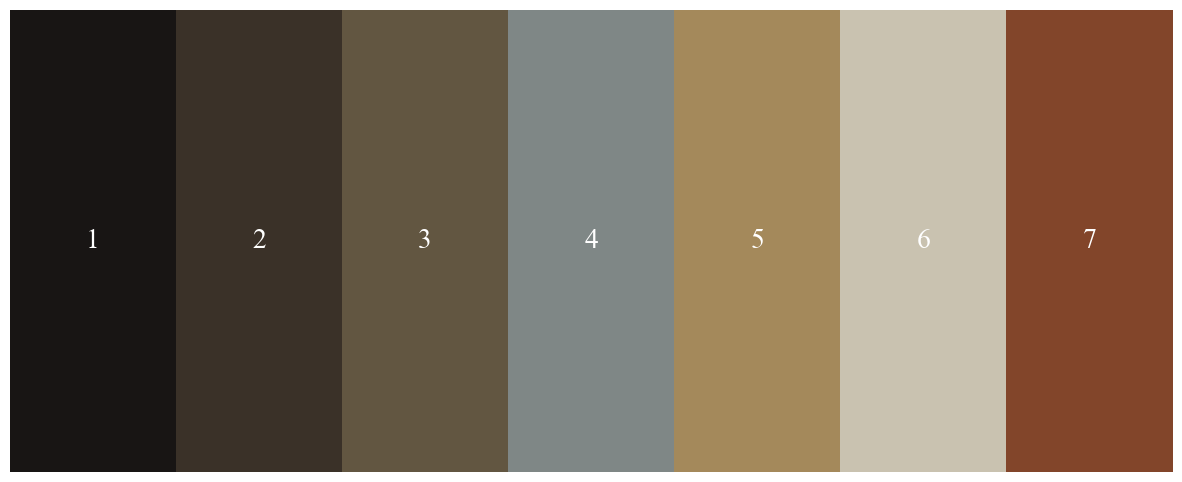

In [207]:
print("Семь самых распространенных цветов (RGB -> LAB -> RGB):")
c = 1
for i in most_common_colors:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors)

##### С переводом из RGB в LAB с помощью GaussianMixture:

In [208]:
most_common_colors_gauss = find_most_common_colors(pixels_vector, rgb_lab='LAB', classifier_type='GM', n_colors=7)

Семь самых распространенных цветов (RGB):
Цвет 1: [43 37 31]
Цвет 2: [91 79 63]
Цвет 3: [16 15 14]
Цвет 4: [187 177 158]
Цвет 5: [135 139 133]
Цвет 6: [144 121  84]
Цвет 7: [97 54 38]


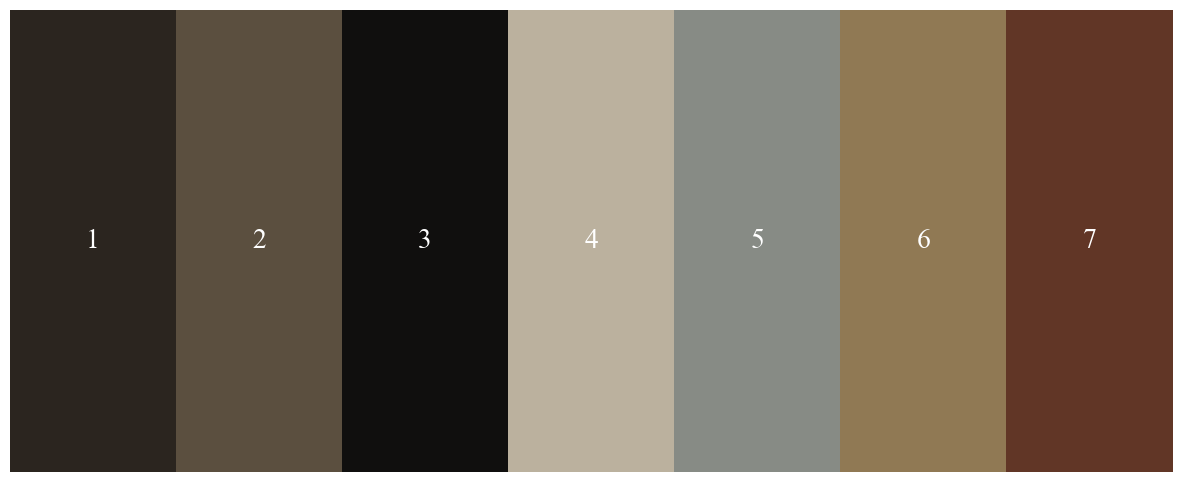

In [209]:
print("Семь самых распространенных цветов (RGB):")
c = 1
for i in most_common_colors_gauss:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors_gauss)

##### С переводом из RGB в LAB с помощью BayesianGaussianMixture:

In [210]:
most_common_colors_gaussbayes = find_most_common_colors(pixels_vector, rgb_lab='LAB', classifier_type='GMM', n_colors=7)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Семь самых распространенных цветов (RGB):
Цвет 1: [57 47 38]
Цвет 2: [29 27 24]
Цвет 3: [144 139 127]
Цвет 4: [119  97  71]
Цвет 5: [8 8 7]
Цвет 6: [159 155 133]
Цвет 7: [103  56  37]


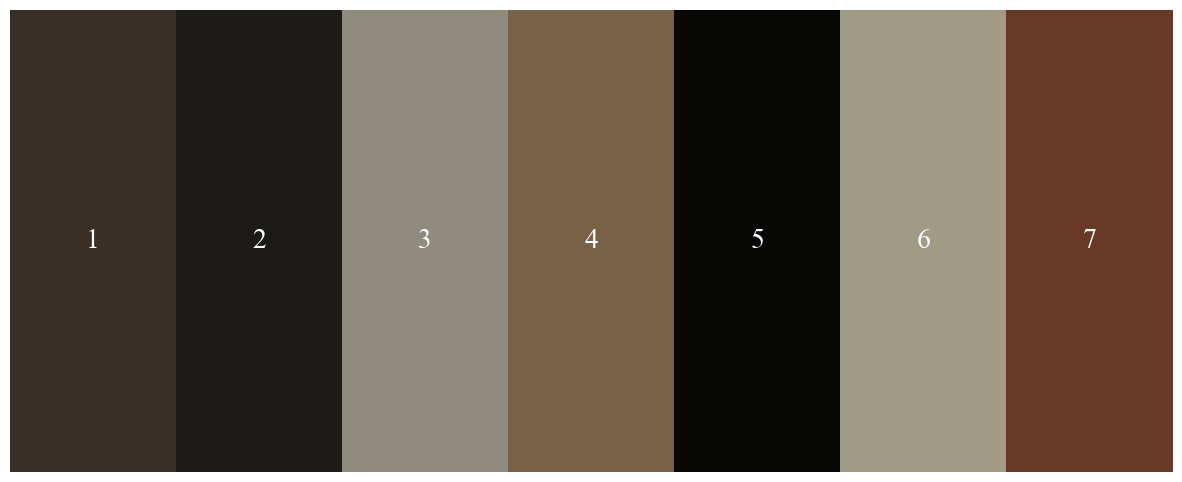

In [211]:
print("Семь самых распространенных цветов (RGB):")
c = 1
for i in most_common_colors_gaussbayes:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors_gaussbayes)

### Смотрим, как часто эти цвета встречаются по годам

In [216]:
def sum_pixels_by_year(results, years):

    summed_results = {color: [] for color in results.keys()}
    unique_years = sorted(list(set(years)))

    for year in unique_years:
        indices = [i for i, y in enumerate(years) if y == year]
        for color in results.keys():
            summed_value = np.sum([results[color][i] for i in indices])
            summed_results[color].append(summed_value)

    return summed_results, unique_years

def min_max_normalization(data):
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) for x in data]

def count_pixels_in_range(image_path, color, tolerance=20):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))
    img_array = np.array(img)

    # defining the boundaries for each channel
    lower_bound = np.array(color) - tolerance
    upper_bound = np.array(color) + tolerance

    # mask for pixels falling within the range
    mask = np.all((img_array >= lower_bound) & (img_array <= upper_bound), axis=-1)

    return np.sum(mask)  # number of pixels corresponding to color

def extract_date_from_filename(filename):
    try:
        year, month, day = map(int, filename.split('_')[:3])
        return datetime(year, month, day)
    except (IndexError, ValueError):
        return None
    
def extract_year_from_filename(filename):
    try:
        year = int(filename.split('_')[0])
        return year
    except (IndexError, ValueError):
        return None 
    
def analyze_most_popular_ever_colors(folder_path, colors):

    results = {tuple(color): [] for color in colors}
    years = []
    files = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            # files.append(filename)
            image_path = os.path.join(folder_path, filename)
            
            year = extract_year_from_filename(filename)
            if year is None:
                continue
            years.append(year)
            files.append(filename)

            pixel_counts = []
            for color in colors:
                count = count_pixels_in_range(image_path, color, tolerance=20)
                pixel_counts.append(count)

            for i, color in enumerate(colors):
                results[tuple(color)].append(pixel_counts[i])

    # converting the results into a numpy array for sorting
    years = np.array(years)
    for color in results:
        results[color] = np.array(results[color])

    # sorting by year
    sorted_indices = np.argsort(years)
    years = years[sorted_indices]
    for color in results:
        results[color] = results[color][sorted_indices]

    return results, years, files

In [213]:
def plot_bar_distribution(results, years, model_name):
    
    results, years = sum_pixels_by_year(results, years)

    colors = list(results.keys())
    counts = np.array(list(results.values()))

    year_pixel_counts = {year: np.zeros(len(colors)) for year in years}

    # sum pixels by year
    for i, year in enumerate(years):
        for j, color in enumerate(colors):
            year_pixel_counts[year][j] += counts[j][i]

    # converting the data into an array to build a graph
    summed_counts = np.array(list(year_pixel_counts.values()))
    summed_counts = summed_counts / summed_counts.sum(axis=1, keepdims=True)

    # convert colors to format for matplotlib (from 0 to 1)
    color_palette = [(r/255, g/255, b/255) for r, g, b in colors]

    sns.set_theme(style="white")
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    
    plt.figure(figsize=(15, 10))

    bottom = np.zeros(len(years))
    for i, color in enumerate(colors):
        plt.bar(range(len(years)), summed_counts[:, i], bottom=bottom, color=color_palette[i], label=f'Color {color}')
        bottom += summed_counts[:, i]  # update the lower limit for accumulation

    plt.title(f'Распределение 7 самых часто встречающихся цветов по годам ({model_name})', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('Год', fontdict={'fontsize': 12})
    plt.ylabel('Количество пикселей (нормализованное)', fontdict={'fontsize': 12})
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    plt.show()

#### KMeans:

In [35]:
results, years, files = analyze_most_popular_ever_colors(folder_path, np.array(most_common_colors))

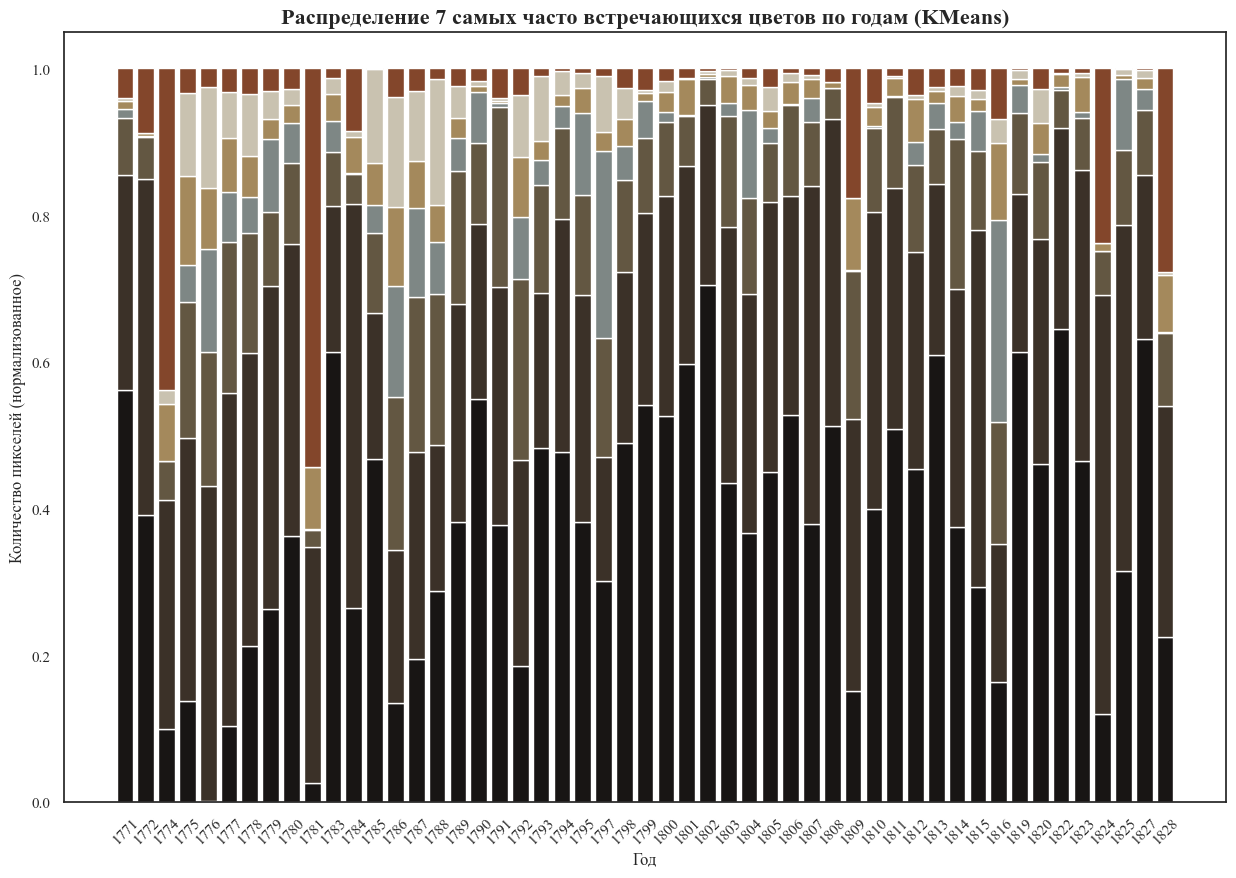

In [36]:
plot_bar_distribution(results, years, model_name='KMeans')

In [69]:
from pprint import pprint

pprint(results)

{(36, 35, 39): array([4176, 5327,  252, 6388, 5862, 2627, 1317, 1811, 1190,  520, 4914,
        983, 1291, 2738, 3411, 3474,  961, 5304, 1058,   23, 1357,  175,
       1063, 1191, 6181, 6676,  200, 1295, 4430, 4405, 2730, 3231,   52,
       1114, 6089, 5393,    9, 5296, 2052, 1742, 2104, 1645, 2789, 2263,
        769, 3340,  340, 3438,    5, 2154, 2344, 4371, 1434, 1266,  300,
        218, 5565, 5422, 2357, 6088, 1142, 2779, 2884, 2751,  590, 8034,
       4015, 2967, 3934,  964, 1792,  309,   12,  633,  904, 4790,  877,
       5103, 2574,  991, 5499, 1300, 1126, 3075,  557, 4041, 6543, 8137,
       4510, 6195, 4586, 1088, 5990, 1092, 4730,  695, 3304, 4185, 3707,
       7420, 2045, 3307, 4149, 6222, 6997,  102, 3534,  326, 2605, 5572,
        283, 2512, 1723, 1373, 2138,  330, 8528,  820, 2769, 1991, 2531,
       1695, 1242, 2190, 1226, 1639, 1322, 3739, 1315, 1187,  455,  215,
       3188, 4959, 4921, 3022, 5127, 4329, 4286, 2600,  940,  441,  657,
       3934, 3322, 1678, 4534, 1910,

In [70]:
df_KMeans = pd.DataFrame.from_dict(results, orient='index', columns=years)
df_KMeans = df_KMeans.T
df_KMeans = df_KMeans.reset_index().rename(columns={'index': 'year'})

In [71]:
df_KMeans = df_KMeans.groupby('year', as_index=False).sum()

In [72]:
df_KMeans.head()

,year,"(36, 35, 39)","(76, 70, 60)","(197, 189, 178)","(135, 123, 95)","(100, 117, 145)","(153, 80, 50)","(198, 159, 84)"
0,1882,9503,3978,269,802,0,5,7
1,1883,252,884,463,2527,0,189,68
2,1885,6388,3420,602,407,22,49,29
3,1886,5862,1731,254,948,10,126,30
4,1888,2627,2598,22,990,1,502,1049


#### GaussianMixture:

In [217]:
results_GM, years, files = analyze_most_popular_ever_colors(folder_path, np.array(most_common_colors_gauss))

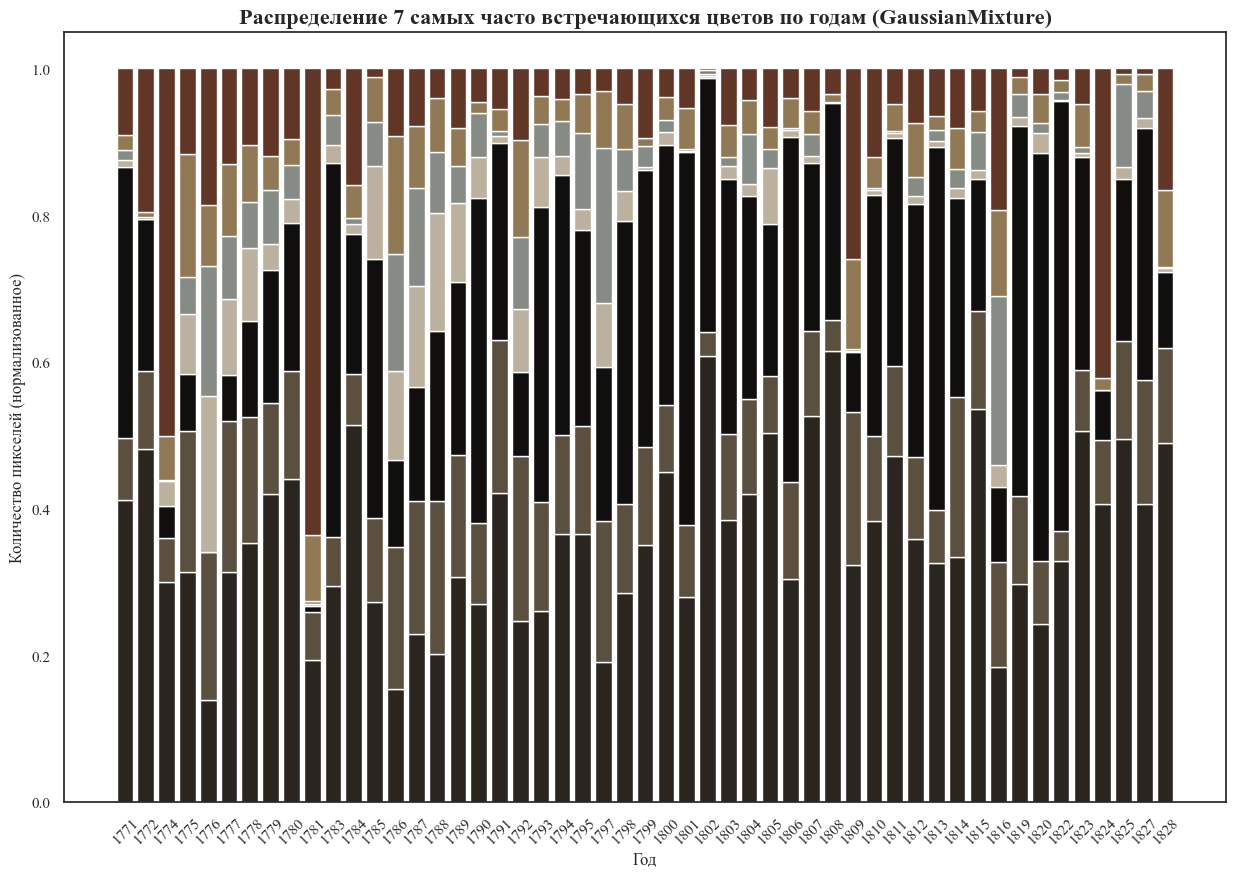

In [38]:
plot_bar_distribution(results_GM, years, model_name='GaussianMixture')

In [230]:
df_GM = pd.DataFrame.from_dict(results_GM, orient='index', columns=years)
df_GM = df_GM.T
df_GM = df_GM.reset_index().rename(columns={'index': 'year'})
df_GM = df_GM.groupby('year', as_index=False).sum()
df_GM.head()

,year,"(43, 37, 31)","(91, 79, 63)","(16, 15, 14)","(187, 177, 158)","(135, 139, 133)","(144, 121, 84)","(97, 54, 38)"
0,1771,27001,5613,24229,678,884,1347,5954
1,1772,11089,2464,4784,0,38,184,4501
2,1774,3994,798,586,451,19,799,6692
3,1775,9032,5565,2260,2369,1441,4847,3373
4,1776,1140,1657,0,1734,1460,681,1526


In [231]:
len(df_GM)

51

In [232]:
len(files)

245

In [233]:
len(results_GM)

7

In [234]:
num = 1
sl = {}
for i in results_GM:
    print(results_GM[i][num])
    print(i)

9265
(43, 37, 31)
767
(91, 79, 63)
4769
(16, 15, 14)
94
(187, 177, 158)
2
(135, 139, 133)
243
(144, 121, 84)
607
(97, 54, 38)


In [235]:
for j in results_GM:
    print(results_GM[j][77])

1869
5020
353
1441
1139
489
471


In [236]:
len(files)

245

In [237]:
len(results_GM)

7

In [238]:
n = 0

for j in results_GM:
    print(results_GM[j][n])
    n+=1

5026
767
8957
0
878
5
1527


In [266]:
info_dict = {}

num = 0
for i in files:
    if (i.split('_')[0] != 'yyyy') and i != '.DS_Store':
        col = {}
        for j in results_GM:
            col[str(j)] = results_GM[j][num]
        info_dict[i] = {
            'path': i,
            'name_of_painting': ' '.join((i.split('_')[4:])).replace('.jpeg', ''),
            'year': i.split('_')[0],
            'most_common_colors_ever': col
        }
        num += 1

In [267]:
info_dict

{'1799_mm_dd_i_Тирана.jpeg': {'path': '1799_mm_dd_i_Тирана.jpeg',
  'name_of_painting': 'Тирана',
  'year': '1799',
  'most_common_colors_ever': {'(43, 37, 31)': 5026,
   '(91, 79, 63)': 0,
   '(16, 15, 14)': 9495,
   '(187, 177, 158)': 0,
   '(135, 139, 133)': 0,
   '(144, 121, 84)': 1,
   '(97, 54, 38)': 683}},
 '1775_mm_dd_i_Охота.jpeg': {'path': '1775_mm_dd_i_Охота.jpeg',
  'name_of_painting': 'Охота',
  'year': '1775',
  'most_common_colors_ever': {'(43, 37, 31)': 9265,
   '(91, 79, 63)': 767,
   '(16, 15, 14)': 4769,
   '(187, 177, 158)': 94,
   '(135, 139, 133)': 2,
   '(144, 121, 84)': 243,
   '(97, 54, 38)': 607}},
 '1812_mm_dd_i_Деревенская_коррида.jpeg': {'path': '1812_mm_dd_i_Деревенская_коррида.jpeg',
  'name_of_painting': 'Деревенская коррида',
  'year': '1812',
  'most_common_colors_ever': {'(43, 37, 31)': 5111,
   '(91, 79, 63)': 775,
   '(16, 15, 14)': 8957,
   '(187, 177, 158)': 0,
   '(135, 139, 133)': 0,
   '(144, 121, 84)': 147,
   '(97, 54, 38)': 1180}},
 '1787_mm

In [268]:
for i in files: 
    print(' '.join((i.split('_')[4:])).replace('.jpg', ''))

Тирана.jpeg
Совет Филиппин.jpeg
Охота.jpeg
Деревенская коррида.jpeg
Портрет испанского короля Карла III.jpeg
Махи на балконе.jpeg
Герцогиня Альба и дуэнья "Ла Беата".jpeg
Портрет Тибурсио Переса-и-Куэрво.jpeg
Жозефа Байе или Леокадия Вейс.jpeg
Хосе Монино Редондо, граф Флоридабланка.jpeg
Автопортрет.jpeg
Портрет доньи Антонии Сарате.jpeg
Портрет Фердинанда VII де Бурбона, короля Испании.jpeg
Расстрел повстанцев 3 мая 1808 года в Мадриде.jpeg
Карл IV.jpeg
Фреска часовни Св. Антония Флоридского, деталь 4.jpeg
Кузница.jpeg
Граф Тахо.jpeg
Точильщик.jpeg
Прогулка в Андалусии.jpeg
Мёртвая индейка.jpeg
Портрет матадора Педро Ромеро.jpeg
Портрет Бартоломе Суреда-и-Мизероль.jpeg
Женщина с двумя мальчиками у фонтана.jpeg
Охота на приманку.jpeg
Бродячие комедианты.jpeg
Победоносный Ганнибал впервые видит Италию с вершин Альп.jpeg
Пьяный каменщик (эскиз).jpeg
Процессия флагеллантов (бичующихся).jpeg
Портрет дона Себастьяна Габриеля де Борбона-и-Браганца.jpeg
Венера и Адонис.jpeg
Мальчики с м

#### BayesianGaussianMixture:

In [50]:
results_BGM, years = analyze_most_popular_ever_colors(folder_path, np.array(most_common_colors_gaussbayes))

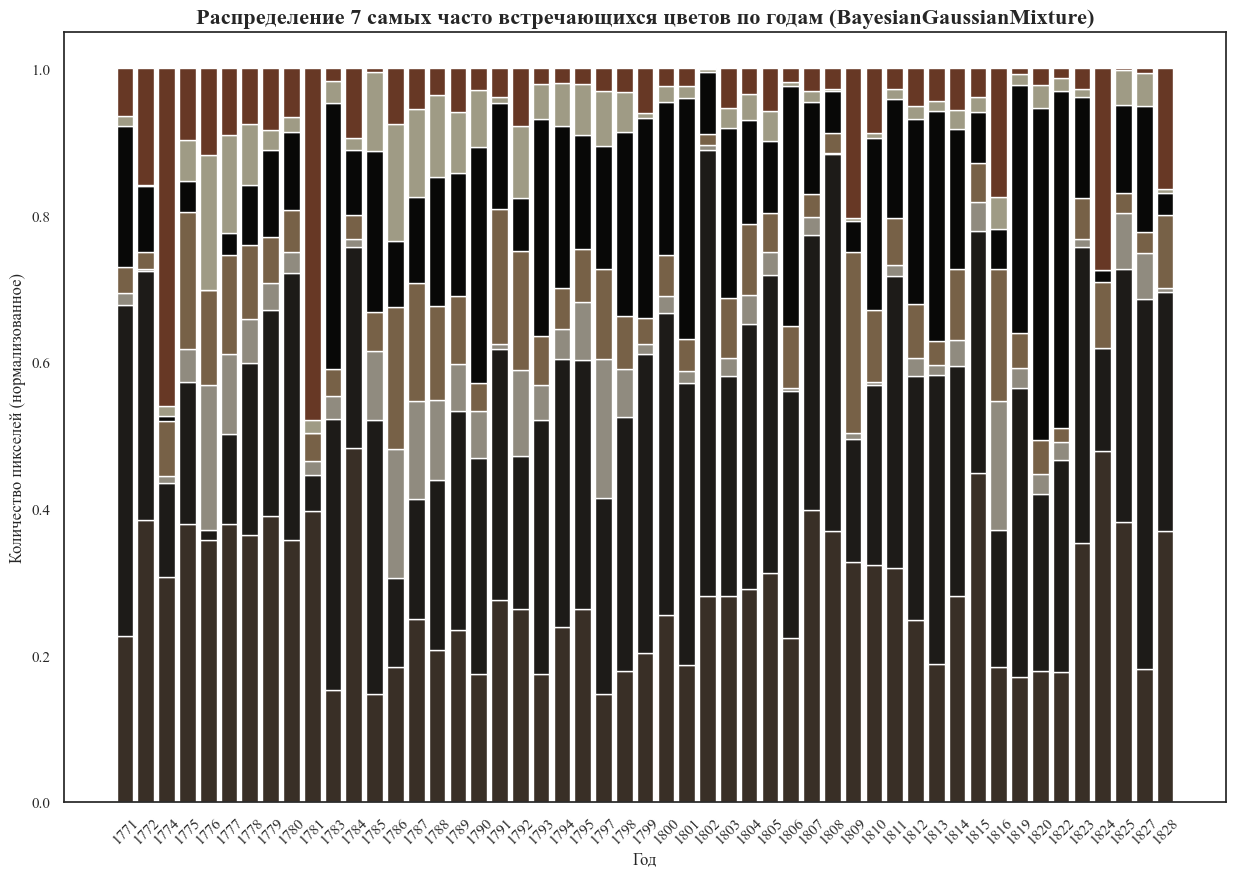

In [51]:
plot_bar_distribution(results_BGM, years, model_name='BayesianGaussianMixture')

In [79]:
df_BGM = pd.DataFrame.from_dict(results_BGM, orient='index', columns=years)
df_BGM = df_BGM.T
df_BGM = df_BGM.reset_index().rename(columns={'index': 'year'})
df_BGM = df_BGM.groupby('year', as_index=False).sum()
df_BGM.head()

,year,"(126, 124, 113)","(51, 50, 49)","(125, 78, 53)","(199, 164, 114)","(201, 195, 184)","(21, 22, 24)","(55, 73, 93)"
0,1882,471,11074,229,1465,303,11192,1388
1,1883,814,321,1403,1988,492,135,17
2,1885,577,6982,126,103,561,2532,481
3,1886,307,5684,612,469,154,4721,477
4,1888,333,2897,1588,1141,20,1710,20


In [80]:
len(df_BGM)

49

#### KMeans (без перевода в LAB):

In [52]:
results_gb, years = analyze_most_popular_ever_colors(folder_path, np.array(most_common_colors_nolab))

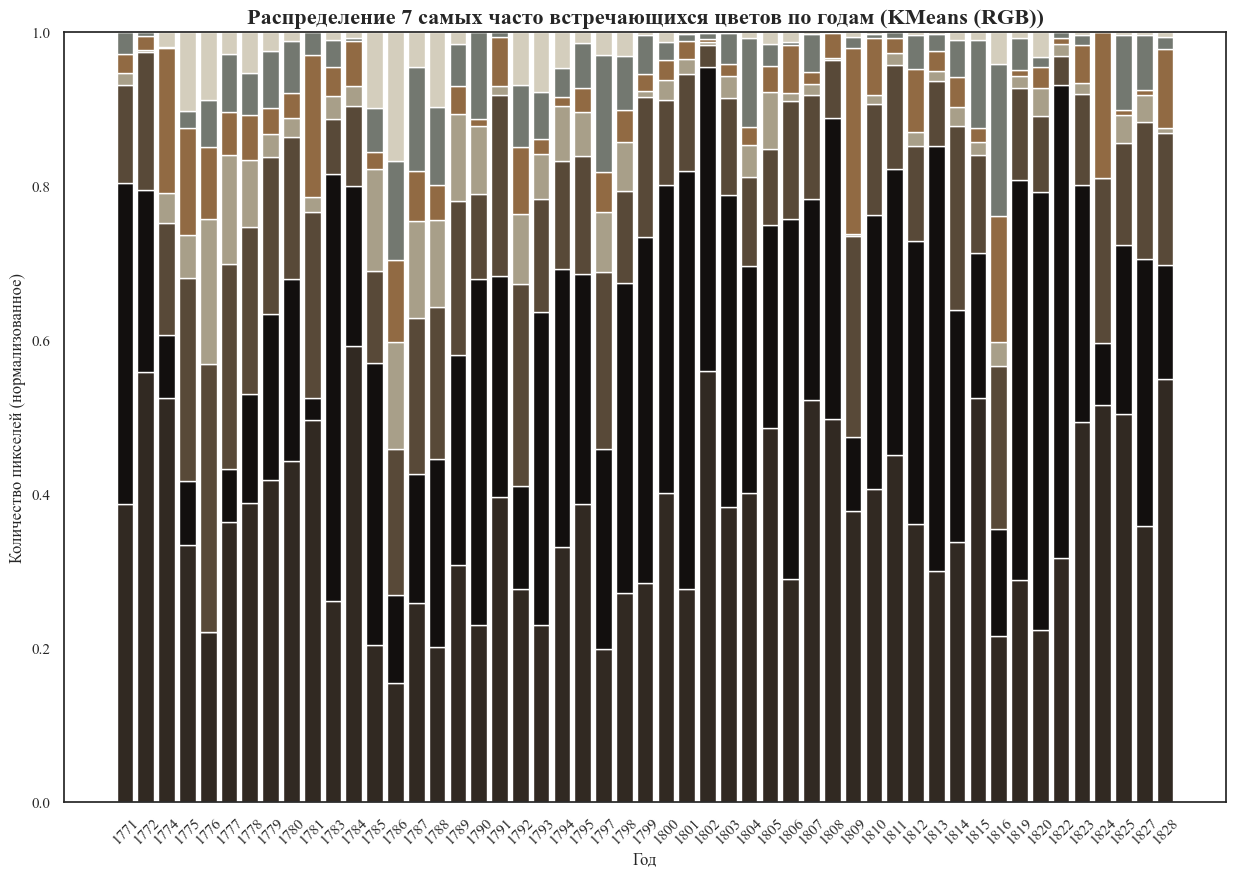

In [53]:
plot_bar_distribution(results_gb, years, model_name='KMeans (RGB)')

### Смотрим отдельно основные цвета

In [54]:
def is_color_in_range(lab_pixel, lower_bound, upper_bound):
    return np.all((lab_pixel >= lower_bound) & (lab_pixel <= upper_bound))

In [55]:
def count_pixels_in_color_range(image_path, lower_bound, upper_bound):
    img = cv2.imread(image_path)
    
    img = cv2.resize(img, (128, 128)) 
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_array = img_lab.reshape(-1, 3)
    
    mask = np.apply_along_axis(is_color_in_range, 1, lab_array, lower_bound, upper_bound)
    total_pixels = lab_array.shape[0]
    
    color_pixel_count = np.sum(mask)
    return color_pixel_count, total_pixels

In [56]:
def analyze_images_in_range(folder_path, lower_bound, upper_bound):
    results = {}
    total_pixels_per_year = {}
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            
            year = extract_year_from_filename(filename)
            if year is None:
                continue
            
            color_count, total_pixels = count_pixels_in_color_range(image_path, lower_bound, upper_bound)
            
            if year in results:
                results[year] += color_count
                total_pixels_per_year[year] += total_pixels
            else:
                results[year] = color_count
                total_pixels_per_year[year] = total_pixels
    
    years = np.array(list(results.keys()))
    normalized_counts = np.array([results[year] for year in years]) # / total_pixels_per_year[year] for year in years])
    
    sorted_indices = np.argsort(years)
    years = years[sorted_indices]
    normalized_counts = normalized_counts[sorted_indices]
    
    return normalized_counts, years

In [57]:
def plot_color_distribution(results, years, color_name, color_hex):
    sns.set_theme(style="white")
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    
    plt.figure(figsize=(15, 10))
    plt.bar(range(len(years)), results, color=color_hex, label=f'{color_name} диапазон')
    plt.title(f'Распределение цвета ({color_name}) по годам', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('Год', fontdict={'fontsize': 12})
    plt.ylabel('Доля пикселей в изображениях', fontdict={'fontsize': 12})
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    # plt.legend(loc='upper left')
    plt.xlim(-0.5, len(years) - 0.5)
    plt.show()

In [58]:
def get_lab_color_range(lab_center, tolerance):
    lower_bound = np.clip(lab_center - tolerance, [0, -128, -128], [100, 127, 127])
    upper_bound = np.clip(lab_center + tolerance, [0, -128, -128], [100, 127, 127])
    return lower_bound, upper_bound

In [59]:
def analyze_images_by_color_mean(folder_path, color):
    results = {}
    total_pixels_per_year = {}
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            
            year = extract_year_from_filename(filename)
            im = cv2.imread(image_path, cv2.IMREAD_COLOR)
            im = cv2.resize(im, (128, 128))
            if color == 'red':
                im = im[:, :, 0]
            elif color == 'green':
                im = im[:, :,1]
            elif color == 'blue':
                im = im[:, :, 2]
            elif color == 'yellow':
                im = im[:, :, 0].astype(float) / 2 + im[:, :, 1].astype(float) / 2
            color_count = im.mean() / 256.

            if year is None:
                continue

            if year in results:
                results[year].append(color_count)
            else:
                results[year] = [color_count]

    for year in results:
        results[year] = np.mean(results[year])

    years = np.array(list(results.keys()))
    normalized_counts = np.array(list(results.values()))
    sorted_indices = np.argsort(years)
    years = years[sorted_indices]
    normalized_counts = normalized_counts[sorted_indices]
    

    return normalized_counts, years

#### Красный:

In [60]:
results, years = analyze_images_by_color_mean(folder_path, color='red')
results

array([0.15827646, 0.11685479, 0.22710907, 0.39117593, 0.34759378,
       0.34941157, 0.30679855, 0.28520525, 0.25358588, 0.2195456 ,
       0.20100226, 0.16075444, 0.34723401, 0.41672312, 0.34928819,
       0.35090516, 0.25672588, 0.22502971, 0.17337084, 0.36428431,
       0.29485731, 0.28479725, 0.26642405, 0.31754661, 0.24869184,
       0.21988835, 0.19356537, 0.16695809, 0.15876222, 0.17827916,
       0.25158882, 0.23356926, 0.16306273, 0.15962601, 0.15402102,
       0.23456883, 0.15739264, 0.15288591, 0.18893235, 0.20995969,
       0.2174032 , 0.21931326, 0.330616  , 0.18938583, 0.15890431,
       0.11586595, 0.1819764 , 0.17229283, 0.22513247, 0.21129799,
       0.1928637 ])

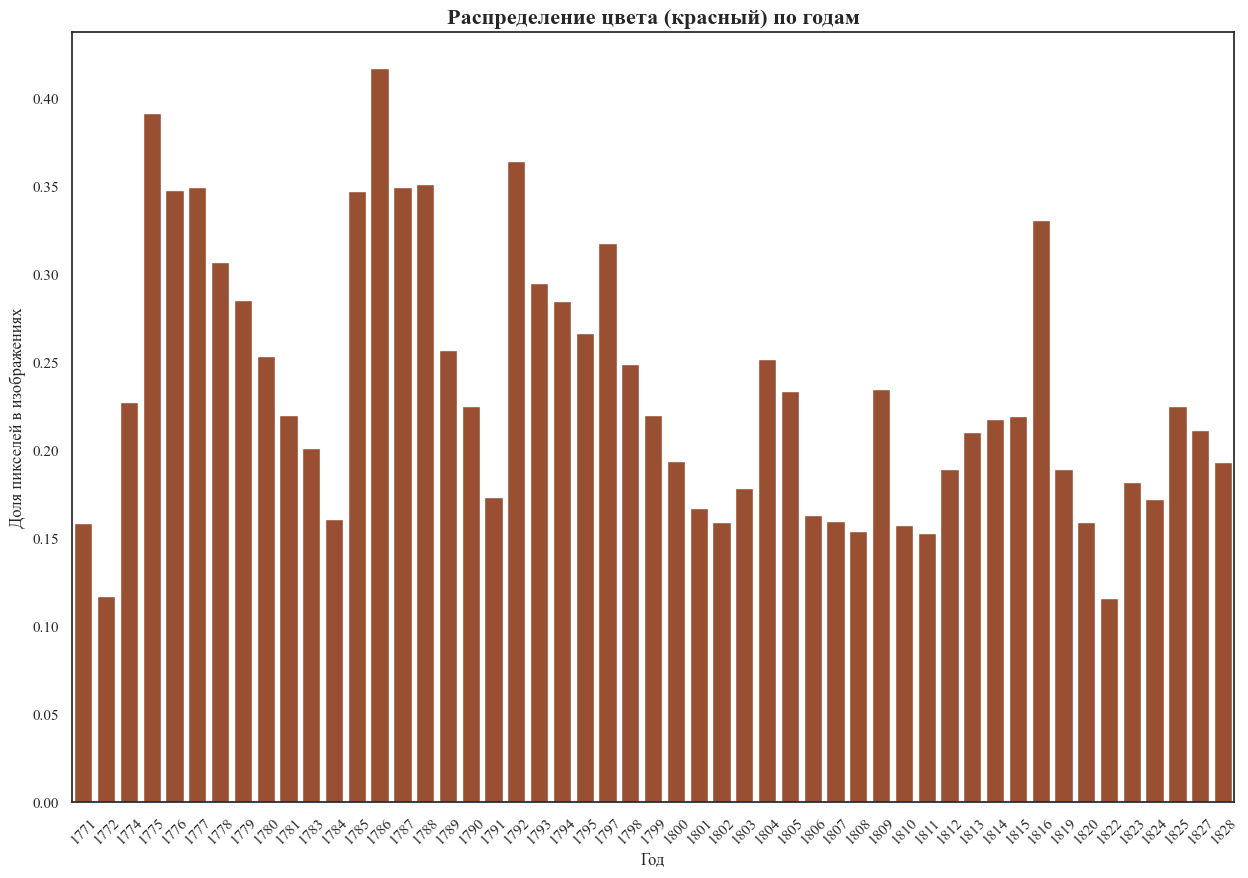

In [61]:
color_hex = '#{:02x}{:02x}{:02x}'.format(152, 79, 50)
plot_color_distribution(results, years, color_name="красный", color_hex=color_hex)

#### Зеленый:

In [62]:
results, years = analyze_images_by_color_mean(folder_path, color='green')

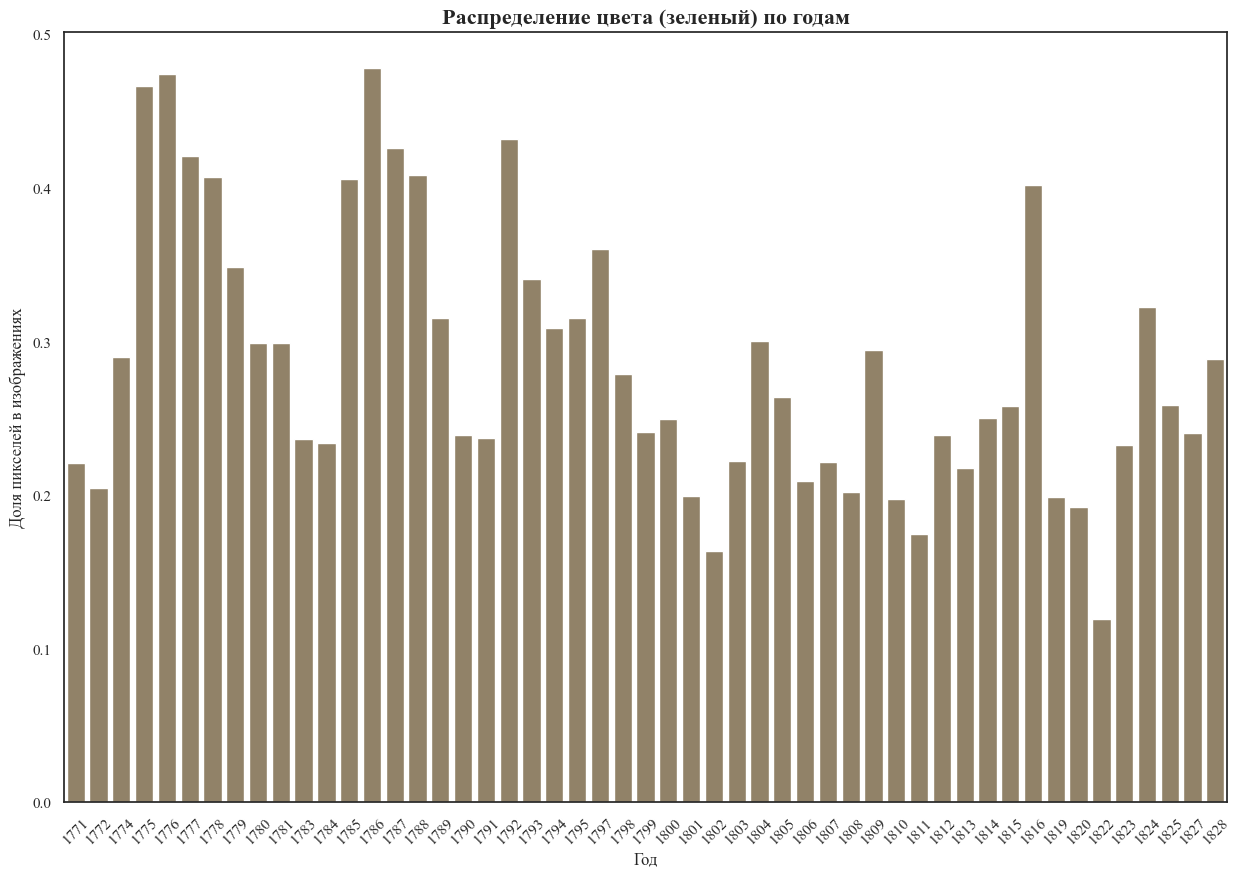

In [63]:
color_hex = '#{:02x}{:02x}{:02x}'.format(145, 130, 104)
plot_color_distribution(results, years, color_name="зеленый", color_hex=color_hex)

#### Синий:

In [64]:
results, years = analyze_images_by_color_mean(folder_path, color='blue')

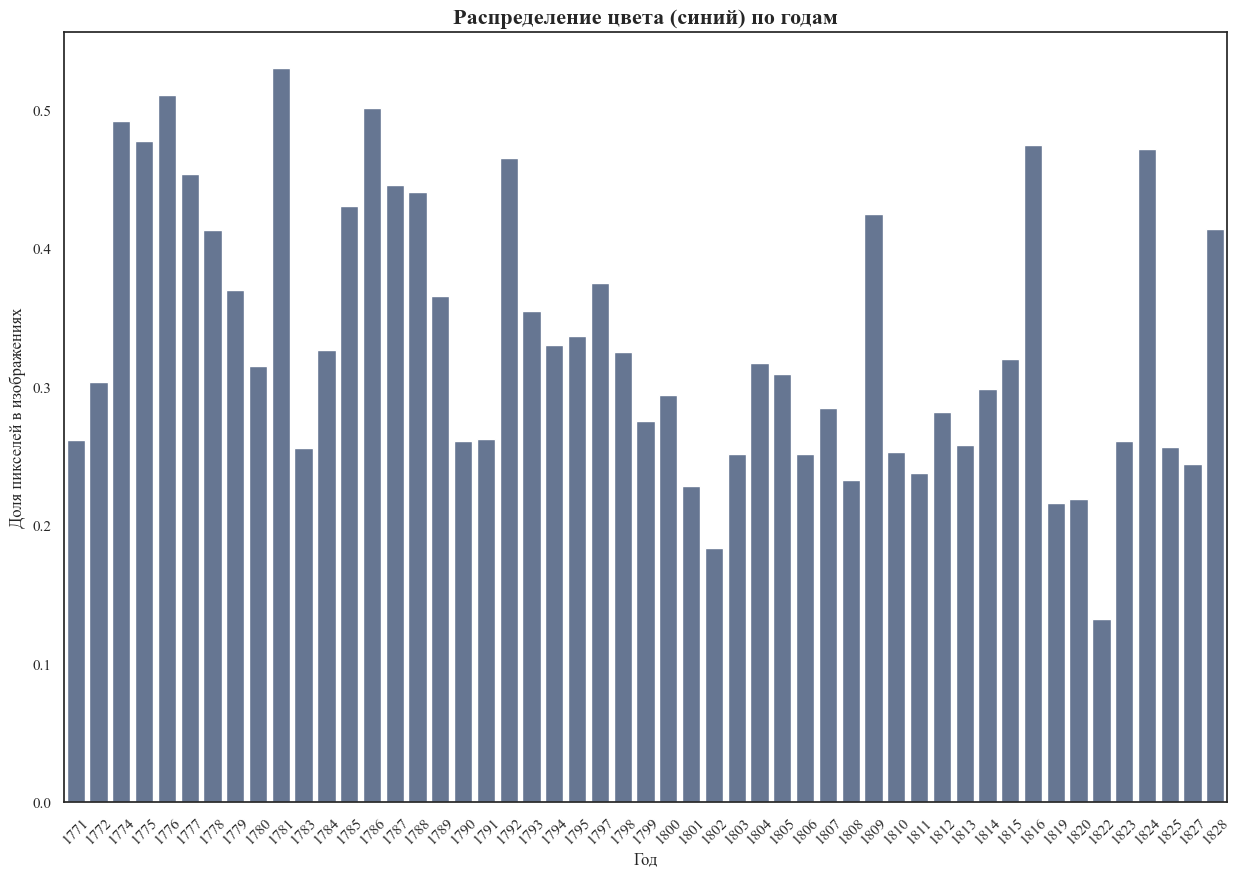

In [65]:
color_hex = '#{:02x}{:02x}{:02x}'.format(102, 118, 146)
plot_color_distribution(results, years, color_name="синий", color_hex=color_hex)

#### Желтый:

In [66]:
results, years = analyze_images_by_color_mean(folder_path, color='yellow')

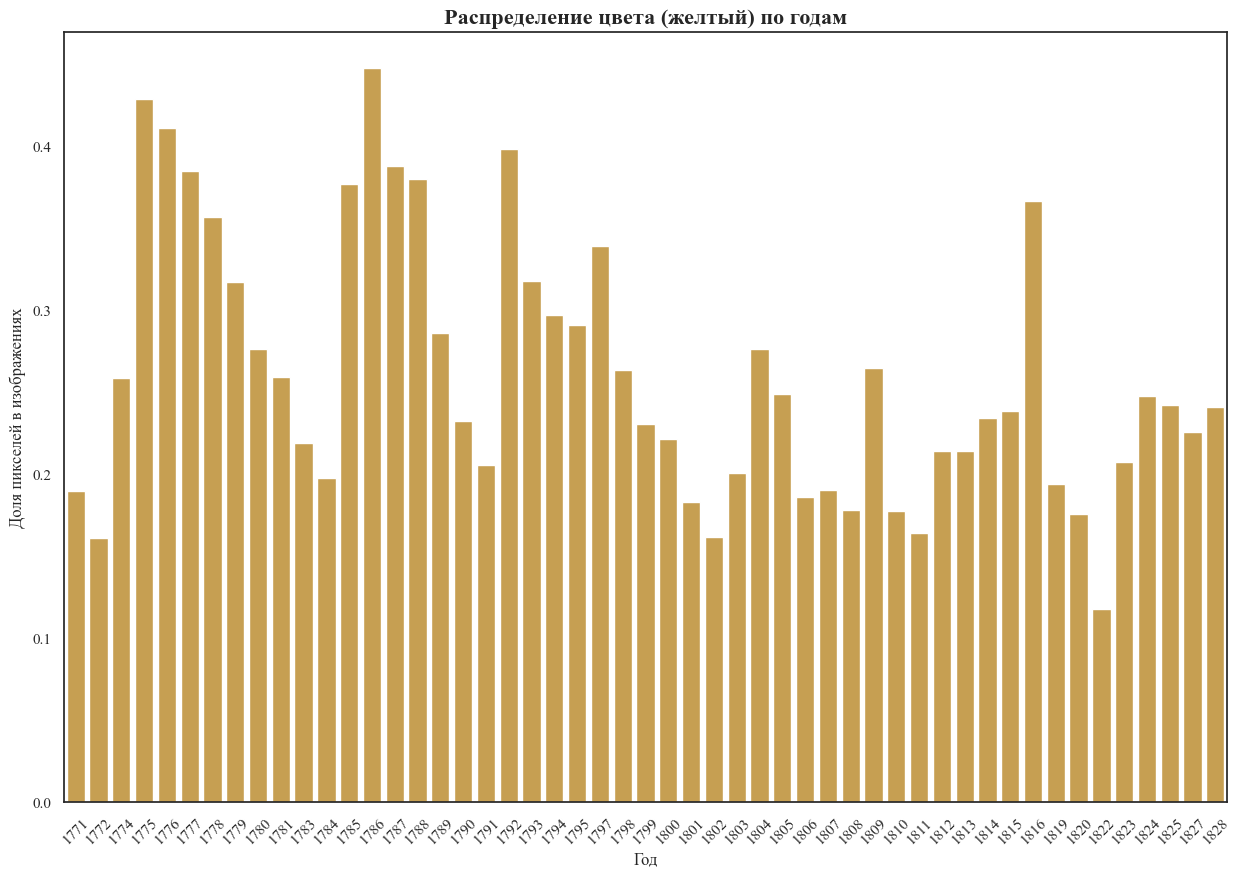

In [67]:
color_hex = '#{:02x}{:02x}{:02x}'.format(198, 159, 82)
plot_color_distribution(results, years, color_name="желтый", color_hex=color_hex)

### Смотрим 7 самых часто используемых цветов за каждый год

In [221]:
def rgb_to_lab(rgb_pixels):
    rgb_pixels = rgb_pixels / 255.0
    lab_pixels = scolor.rgb2lab(rgb_pixels.reshape(-1, 1, 3)).reshape(-1, 3)
    return lab_pixels

# def rgb_to_lab(rgb_pixels):
#     rgb_pixels = np.array(rgb_pixels, dtype=np.float64) / 255.0
#     lab_pixels = scolor.rgb2lab(rgb_pixels.reshape(-1, 1, 3)).reshape(-1, 3)
#     return lab_pixels

def lab_to_rgb(lab_color):
    lab_color = np.array(lab_color).reshape(1, 1, 3)
    rgb_color = scolor.lab2rgb(lab_color).reshape(3) * 255
    rgb_color = np.clip(rgb_color, 0, 255).astype(int)
    return tuple(rgb_color)

In [220]:
def get_most_common_colors(image_path, classifier, num_colors=7, resize_dim=(128, 128), rounding=10):
# def get_most_common_colors(image_path, classifier, num_colors=7, resize_dim=(50, 50), rounding=10):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(resize_dim)
    pixels = np.array(image).reshape(-1, 3)
    pixels = rgb_to_lab(pixels)

    if classifier == 'Counter':
        pixels = (pixels // rounding) * rounding
        color_counter = Counter(map(tuple, pixels))  # Преобразуем в кортежи
        most_common = color_counter.most_common(num_colors)
    
    elif classifier == 'KMeans':
        kmeans = KMeans(n_clusters=num_colors, random_state=42)
        kmeans.fit(pixels)
        labels = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_
        
        color_counter = Counter(labels)
        most_common1 = color_counter.most_common(num_colors)
        
        most_common = []
        for cluster_idx, count in most_common1:
            lab_color = cluster_centers[cluster_idx]
            rgb_color = lab_to_rgb(lab_color)
            # most_common.append((rgb_color, count))
            # most_common.append((tuple(rgb_color.astype(int)), count))
            most_common.append((rgb_color, count))
            

    elif classifier == 'GM':
        gmm = GaussianMixture(n_components=num_colors, random_state=42)
        gmm.fit(pixels)
        labels = gmm.predict(pixels)
        cluster_centers = gmm.means_

        # Подсчет количества пикселей в каждом кластере
        color_counter = Counter(labels)
        most_common_labels = color_counter.most_common(num_colors)

        most_common = []
        for cluster_idx, count in most_common_labels:
            lab_color = cluster_centers[cluster_idx]
            rgb_color = scolor.lab2rgb(lab_color.reshape(1, 1, 3)).reshape(3) * 255  # LAB → RGB
            most_common.append((tuple(rgb_color.astype(int)), count))  # Преобразуем в кортеж
            
    elif classifier == 'GMM':
        gmm = BayesianGaussianMixture(n_components=num_colors, random_state=42)
        gmm.fit(pixels)
        labels = gmm.predict(pixels)
        cluster_centers = gmm.means_
        
        color_counter = Counter(labels)
        most_common1 = color_counter.most_common(num_colors)
        
        most_common = []
        for cluster_idx, count in most_common1:
            lab_color = cluster_centers[cluster_idx]
            rgb_color = lab_to_rgb(lab_color)
            most_common.append((rgb_color, count))

    return most_common  # Список (цвет, количество пикселей)

In [222]:
# def get_colors_by_year(images_folder, classifier):
    
#     colors_by_year = {}
    
#     for file in os.listdir(images_folder):
#         if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
#             try:
#                 year = file.split('_')[0]
#                 year = int(year)
#             except ValueError:
#                 continue
            
#             image_path = os.path.join(images_folder, file)
#             common_colors = get_most_common_colors(image_path, classifier)
            
#             if year not in colors_by_year:
#                 colors_by_year[year] = []
            
#             # add color codes and pixel counts
#             for color, count in common_colors:
#                 colors_by_year[year].append((color, count))
    
#     # top-7 by each year
#     top_colors_by_year = {}
#     for year, colors in colors_by_year.items():
#         if classifier == 'KMeans':
#             # color_counter = Counter({tuple(color): count for color, count in colors.items()})
#             color_counter = Counter(dict(colors)) 
#         else:
#             color_counter = Counter(dict(colors)) # count the number of pixels for each color
#         top_colors = color_counter.most_common(7)
#         top_colors_by_year[year] = {color: count for color, count in top_colors}
        
#     print(top_colors_by_year)
    
#     return top_colors_by_year

def get_colors_by_year(images_folder, classifier):
    
    colors_by_year = {}
    
    for file in os.listdir(images_folder):
        if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
            # try:
            #     year = file.split('_')[0]
            #     year = int(year)
            # except ValueError:
            #     continue
            year = file
            
            image_path = os.path.join(images_folder, file)
            common_colors = get_most_common_colors(image_path, classifier)
            
            if year not in colors_by_year:
                colors_by_year[year] = []
            
            # add color codes and pixel counts
            for color, count in common_colors:
                colors_by_year[year].append((color, count))
    
    # top-7 by each year
    top_colors_by_year = {}
    for year, colors in colors_by_year.items():
        if classifier == 'KMeans':
            # color_counter = Counter({tuple(color): count for color, count in colors.items()})
            color_counter = Counter(dict(colors)) 
        else:
            color_counter = Counter(dict(colors)) # count the number of pixels for each color
        top_colors = color_counter.most_common(7)
        top_colors_by_year[year] = {str(color): count for color, count in top_colors}
    
    return top_colors_by_year

In [223]:
def sort_colors_by_luminance(colors):
    # Calculate luminance (L channel) for each color in LAB space and sort by it
    lab_colors = np.array(colors)
    luminance = lab_colors[:, 0]  # L channel in LAB space
    sorted_indices = np.argsort(luminance)  # Sort based on luminance (L channel)
    return np.array(colors)[sorted_indices]

def calculate_brightness(lab_color):
    return lab_color[0]

In [224]:
def plot_color_distribution(colors_by_year, how, classifier):
    years = [year for year in sorted(colors_by_year.keys()) if colors_by_year[year]] # filter the years for which there is data
    print(years)
    
    # all colors
    all_colors = set()
    for color_dict in colors_by_year.values():
        all_colors.update(color_dict.keys())
    all_colors = list(all_colors)
    
    data = {color: [] for color in all_colors}
    
    # Normalize data on the Y axis (0 to 1) for each year
    for year in years:
        year_data = colors_by_year.get(year, {})
        total_pixels = sum(year_data.values())  # sum of all pixels for one year
        if total_pixels == 0: 
            total_pixels = 1
        for color in all_colors:
            count = year_data.get(color, 0)
            normalized_count = count / total_pixels  # normalizing
            data[color].append(normalized_count)
        
    if how == 'sorted':
        # if classifier == 'GM' or classifier == 'KMeans':
        if classifier in {'GM', 'KMeans', 'GMM'}:
            all_colors = sorted(all_colors, key=lambda color: calculate_brightness(rgb_to_lab(np.array([color]))[0]), reverse=False)
        # sorted_colors = sorted(all_colors, key=lambda color: calculate_brightness(rgb_to_lab(np.array([color]))[0]), reverse=False)
        else:
            all_colors = sort_colors_by_luminance(list(all_colors))
    
    bottom = np.zeros(len(years))
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']

    plt.figure(figsize=(15, 8))
    
    for color in all_colors:
        # Converting from LAB to RGB for display on a graph
        if classifier == 'Counter':
            lab_color = np.array(color).reshape(1, 1, 3)
            rgb_color = scolor.lab2rgb(lab_color).reshape(3) 
            rgb_color = np.clip(rgb_color, 0, 1)
        
        if how == 'not_sorted':
            if classifier == 'GM':
                # plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                rgb = ensure_rgb_tuple(color)
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(rgb)/255.0, label=str(rgb))
                bottom += np.array(data[color])
            elif classifier == 'KMeans':
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color])
            elif classifier == 'GMM':
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color])
            else:
                plt.bar(range(len(years)), data[color], bottom=bottom, color=rgb_color, label=str(color))
                bottom += np.array(data[color])
    
        elif how == 'sorted':
            if classifier == 'GM':
                # plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                color_tuple = tuple(color) 
                # plt.bar(range(len(years)), data[color_tuple], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                rgb = ensure_rgb_tuple(color)
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(rgb)/255.0, label=str(rgb))
                bottom += np.array(data[color_tuple])
            elif classifier == 'KMeans':
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color])
            elif classifier == 'GMM':
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color])
            else:
                plt.bar(range(len(years)), data[tuple(color)], bottom=bottom, color=rgb_color, label=str(color))
                bottom += np.array(data[tuple(color)])
    
    plt.xlabel('Год', fontdict={'fontsize': 12})
    plt.ylabel('Нормализованное количество пикселей', fontdict={'fontsize': 12})
    plt.title('Частота использования топ-7 цветов на картинах по годам', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    plt.show()
    
import ast

def ensure_rgb_tuple(color):
    if isinstance(color, str):
        return ast.literal_eval(color)
    return color

#### Counter:

In [76]:
colors_by_year = get_colors_by_year(folder_path, classifier='Counter')

In [103]:
# pprint(colors_by_year)

In [77]:
rows = []
for year, colors in colors_by_year.items():
    for (r, g, b), count in colors.items():
        rows.append((year, r, g, b, count))

df = pd.DataFrame(rows, columns=['year', 'R', 'G', 'B', 'Count'])

ValueError: too many values to unpack (expected 3)

In [105]:
df

,year,R,G,B,Count
0,1938,70.0,-10.0,0.0,1429
1,1938,80.0,-10.0,0.0,695
2,1938,60.0,-10.0,0.0,497
3,1938,0.0,0.0,-10.0,423
4,1938,10.0,0.0,-10.0,397
...,...,...,...,...,...
338,1910,60.0,0.0,30.0,805
339,1910,70.0,-10.0,0.0,753
340,1910,60.0,0.0,20.0,687
341,1910,20.0,-10.0,-10.0,659


In [74]:
plot_color_distribution(colors_by_year, how='not_sorted', classifier='Counter')

ValueError: cannot reshape array of size 1 into shape (1,1,3)

<Figure size 1500x800 with 0 Axes>

Отсортировано по яркости:

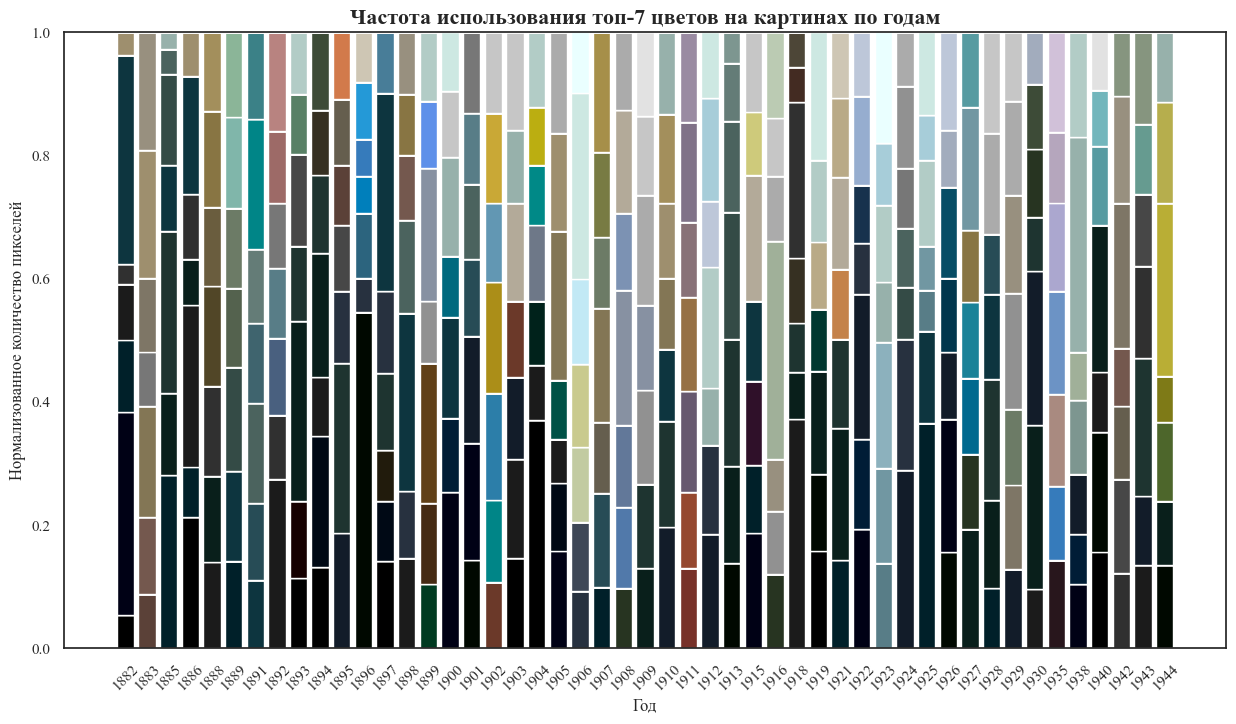

In [107]:
plot_color_distribution(colors_by_year, how='sorted', classifier='Counter')

#### GaussianMixture:

In [269]:
info_dict

{'1799_mm_dd_i_Тирана.jpeg': {'path': '1799_mm_dd_i_Тирана.jpeg',
  'name_of_painting': 'Тирана',
  'year': '1799',
  'most_common_colors_ever': {'(43, 37, 31)': 5026,
   '(91, 79, 63)': 0,
   '(16, 15, 14)': 9495,
   '(187, 177, 158)': 0,
   '(135, 139, 133)': 0,
   '(144, 121, 84)': 1,
   '(97, 54, 38)': 683}},
 '1775_mm_dd_i_Охота.jpeg': {'path': '1775_mm_dd_i_Охота.jpeg',
  'name_of_painting': 'Охота',
  'year': '1775',
  'most_common_colors_ever': {'(43, 37, 31)': 9265,
   '(91, 79, 63)': 767,
   '(16, 15, 14)': 4769,
   '(187, 177, 158)': 94,
   '(135, 139, 133)': 2,
   '(144, 121, 84)': 243,
   '(97, 54, 38)': 607}},
 '1812_mm_dd_i_Деревенская_коррида.jpeg': {'path': '1812_mm_dd_i_Деревенская_коррида.jpeg',
  'name_of_painting': 'Деревенская коррида',
  'year': '1812',
  'most_common_colors_ever': {'(43, 37, 31)': 5111,
   '(91, 79, 63)': 775,
   '(16, 15, 14)': 8957,
   '(187, 177, 158)': 0,
   '(135, 139, 133)': 0,
   '(144, 121, 84)': 147,
   '(97, 54, 38)': 1180}},
 '1787_mm

In [270]:
len(info_dict)

241

In [244]:
colors_by_year_gm = get_colors_by_year(folder_path, classifier='GM')

In [271]:
keys_in_colors = set(colors_by_year_gm.keys())
keys_in_info = set(info_dict.keys())

missing_in_info = keys_in_colors - keys_in_info
print("❗ Ключи, которых нет в info_dict:")
for k in missing_in_info:
    print(k)

❗ Ключи, которых нет в info_dict:
yyyy_mm_dd_i_Портрет_доньи_Терезы_Суреда.jpeg
yyyy_mm_dd_i_Совет_Филиппин.jpeg
yyyy_mm_dd_i_Маскарад_в_Андалусии.jpeg


In [272]:
# for i in colors_by_year_gm:
#     if i.split('_')[0] != 'yyyy':
#         if i in colors_by_year_gm:
#             info_dict[i]['most_common_colors'] = colors_by_year_gm[i]

for i in colors_by_year_gm:
    if i.split('_')[0] != 'yyyy':
        if i in info_dict:
            info_dict[i]['most_common_colors'] = colors_by_year_gm[i]
        else:
            print(f"⚠️ {i} not found in info_dict")

In [273]:
info_dict

{'1799_mm_dd_i_Тирана.jpeg': {'path': '1799_mm_dd_i_Тирана.jpeg',
  'name_of_painting': 'Тирана',
  'year': '1799',
  'most_common_colors_ever': {'(43, 37, 31)': 5026,
   '(91, 79, 63)': 0,
   '(16, 15, 14)': 9495,
   '(187, 177, 158)': 0,
   '(135, 139, 133)': 0,
   '(144, 121, 84)': 1,
   '(97, 54, 38)': 683},
  'most_common_colors': {'(71, 58, 47)': 5240,
   '(78, 50, 40)': 4617,
   '(90, 74, 58)': 2097,
   '(157, 93, 73)': 1278,
   '(116, 52, 51)': 1237,
   '(199, 157, 122)': 1064,
   '(24, 12, 12)': 851}},
 '1775_mm_dd_i_Охота.jpeg': {'path': '1775_mm_dd_i_Охота.jpeg',
  'name_of_painting': 'Охота',
  'year': '1775',
  'most_common_colors_ever': {'(43, 37, 31)': 9265,
   '(91, 79, 63)': 767,
   '(16, 15, 14)': 4769,
   '(187, 177, 158)': 94,
   '(135, 139, 133)': 2,
   '(144, 121, 84)': 243,
   '(97, 54, 38)': 607},
  'most_common_colors': {'(75, 63, 38)': 6465,
   '(113, 92, 53)': 3217,
   '(153, 130, 83)': 2307,
   '(191, 200, 180)': 1859,
   '(139, 169, 159)': 1213,
   '(214, 1

In [274]:
import json

with open("colors_data_goya.json", "w", encoding="utf-8") as f:
    json.dump(info_dict, f, default=str, ensure_ascii=False, indent=4)

[1771, 1772, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1819, 1820, 1822, 1823, 1824, 1825, 1827, 1828]


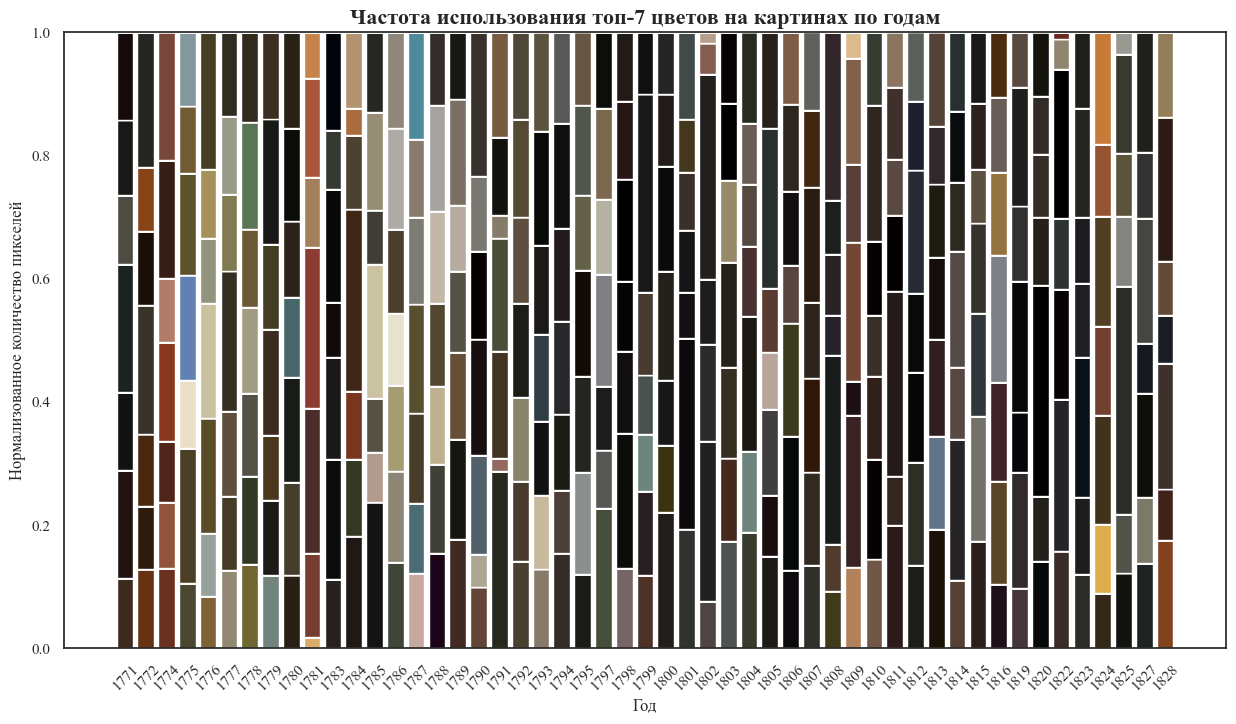

In [130]:
plot_color_distribution(colors_by_year_gm, how='not_sorted', classifier='GM')

Отсортировано по яркости:

[1771, 1772, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1819, 1820, 1822, 1823, 1824, 1825, 1827, 1828]


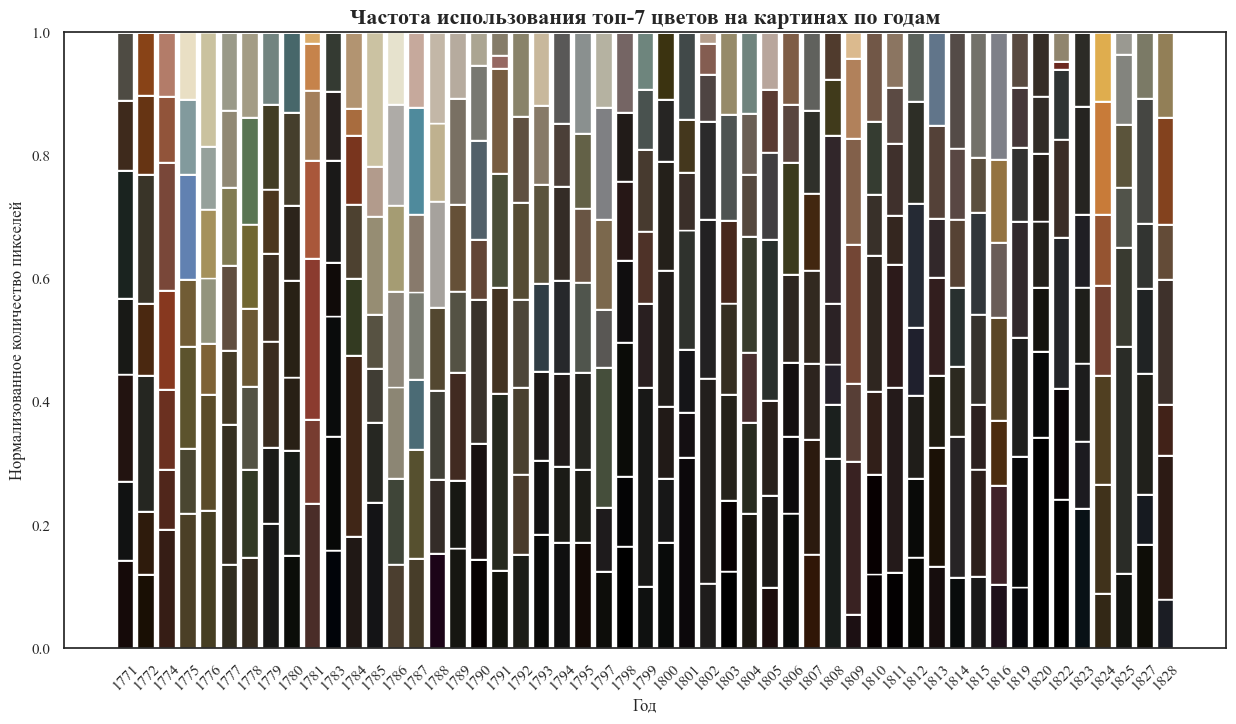

In [131]:
plot_color_distribution(colors_by_year_gm, how='sorted', classifier='GM')

In [111]:
# colors_by_year_gm

In [112]:
rows = []
for year, colors in colors_by_year_gm.items():
    color_list = list(colors.items())[:7]  # Оставляем только 7 цветов
    row = [year]
    for i, ((r, g, b), count) in enumerate(color_list):
        row.extend([r, g, b, count])  # Добавляем R, G, B и Count
    rows.append(row)
    
columns = ['year']
for i in range(1, 8):  # 7 цветов
    columns.extend([f'R{i}', f'G{i}', f'B{i}', f'Count{i}'])

# Создаем DataFrame
df = pd.DataFrame(rows, columns=columns)
df.head()

,year,R1,G1,B1,Count1,R2,G2,B2,Count2,R3,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1938,181,189,177,4582,146,140,132,2878,34,...,103,1676,103,56,52,1650,227,202,112,1548
1,1895,58,59,57,5652,212,122,72,5529,29,...,29,4527,67,61,54,4500,44,35,30,3950
2,1902,18,26,34,5729,34,34,37,5106,183,...,53,4566,27,35,41,4545,213,192,185,4505
3,1893,9,4,5,5059,35,14,13,5026,166,...,44,3942,162,112,77,3804,228,139,70,3518
4,1888,114,97,67,3417,68,63,55,3248,155,...,104,2073,122,82,44,1654,196,153,87,1131


In [113]:
# df_GM

In [114]:
df_GM = pd.merge(df_GM, df, on='year', how='inner')
df_GM.head()

,year,"(35, 36, 39)","(73, 64, 55)","(139, 125, 100)","(192, 184, 173)","(82, 98, 120)","(137, 77, 48)","(199, 160, 96)",R1,G1,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1882,9540,4024,844,230,13,36,271,41,56,...,21,3099,197,163,126,1913,74,64,52,1858
1,1883,242,786,2828,410,1,555,403,179,148,...,196,1206,188,141,112,631,57,44,46,541
2,1885,6573,3510,365,630,106,69,48,55,62,...,182,860,162,147,118,613,100,76,57,485
3,1886,5856,2217,830,376,37,330,120,43,50,...,128,1949,129,92,65,755,154,169,154,466
4,1888,2551,2783,870,21,10,945,1302,114,97,...,104,2073,122,82,44,1654,196,153,87,1131


In [115]:
df_counts['year'] = df_counts['year'].astype(int)

In [116]:
df_GM = pd.merge(df_GM, df_counts, on='year', how='inner')

In [117]:
df_GM.head()

,year,"(35, 36, 39)","(73, 64, 55)","(139, 125, 100)","(192, 184, 173)","(82, 98, 120)","(137, 77, 48)","(199, 160, 96)",R1,G1,...,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7,count
0,1882,9540,4024,844,230,13,36,271,41,56,...,3099,197,163,126,1913,74,64,52,1858,2
1,1883,242,786,2828,410,1,555,403,179,148,...,1206,188,141,112,631,57,44,46,541,1
2,1885,6573,3510,365,630,106,69,48,55,62,...,860,162,147,118,613,100,76,57,485,1
3,1886,5856,2217,830,376,37,330,120,43,50,...,1949,129,92,65,755,154,169,154,466,1
4,1888,2551,2783,870,21,10,945,1302,114,97,...,2073,122,82,44,1654,196,153,87,1131,1


In [118]:
df_GM.to_csv('data_GM.csv', index=False)

#### KMeans:

In [132]:
colors_by_year_km = get_colors_by_year(folder_path, classifier='KMeans')

{1799: {(24, 24, 23): 13299, (30, 22, 25): 6639, (19, 19, 18): 5561, (68, 54, 44): 5475, (16, 12, 15): 4263, (50, 38, 38): 4076, (94, 75, 58): 3539}, 1775: {(96, 127, 175): 4847, (58, 50, 35): 3466, (85, 71, 41): 3316, (125, 151, 155): 3068, (230, 206, 171): 2950, (116, 94, 53): 2924, (74, 70, 49): 2841}, 1812: {(6, 2, 3): 9566, (11, 9, 7): 9565, (13, 13, 10): 8406, (32, 30, 25): 6836, (43, 44, 37): 6781, (39, 45, 53): 6431, (56, 57, 44): 5993}, 1787: {(56, 49, 28): 5487, (79, 138, 157): 5250, (120, 121, 107): 4969, (196, 167, 154): 4486, (61, 57, 40): 4171, (184, 171, 145): 3725, (75, 106, 116): 3643}, 1814: {(39, 35, 37): 11034, (10, 13, 12): 8833, (44, 51, 48): 7762, (15, 10, 12): 5327, (89, 80, 73): 4990, (18, 19, 21): 4976, (51, 46, 35): 4658}, 1795: {(21, 12, 7): 7722, (38, 37, 33): 6670, (14, 15, 12): 6612, (137, 144, 142): 6379, (28, 28, 22): 4803, (18, 18, 16): 4461, (36, 35, 32): 4440}, 1820: {(0, 0, 0): 14907, (11, 12, 13): 8205, (20, 18, 13): 5056, (37, 32, 27): 4804, (32, 

[1771, 1772, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1819, 1820, 1822, 1823, 1824, 1825, 1827, 1828]


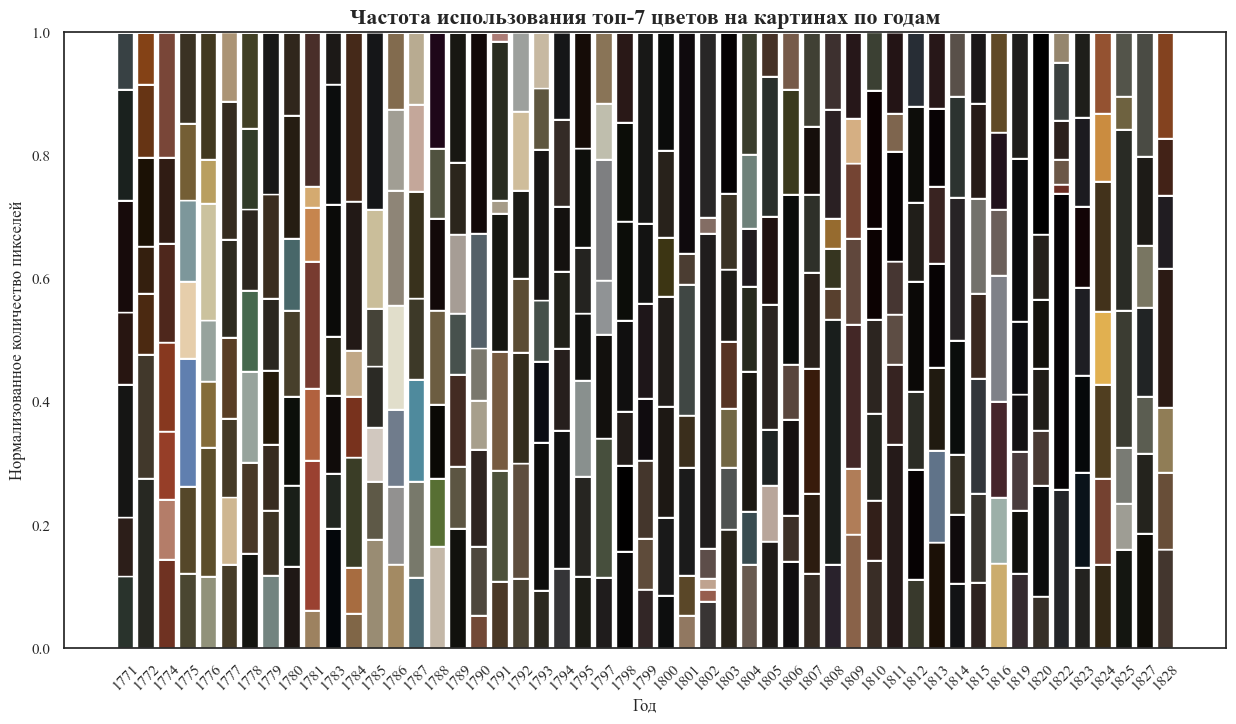

In [133]:
plot_color_distribution(colors_by_year_km, how='not_sorted', classifier='KMeans')

Отсортировано по яркости:

[1771, 1772, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1819, 1820, 1822, 1823, 1824, 1825, 1827, 1828]


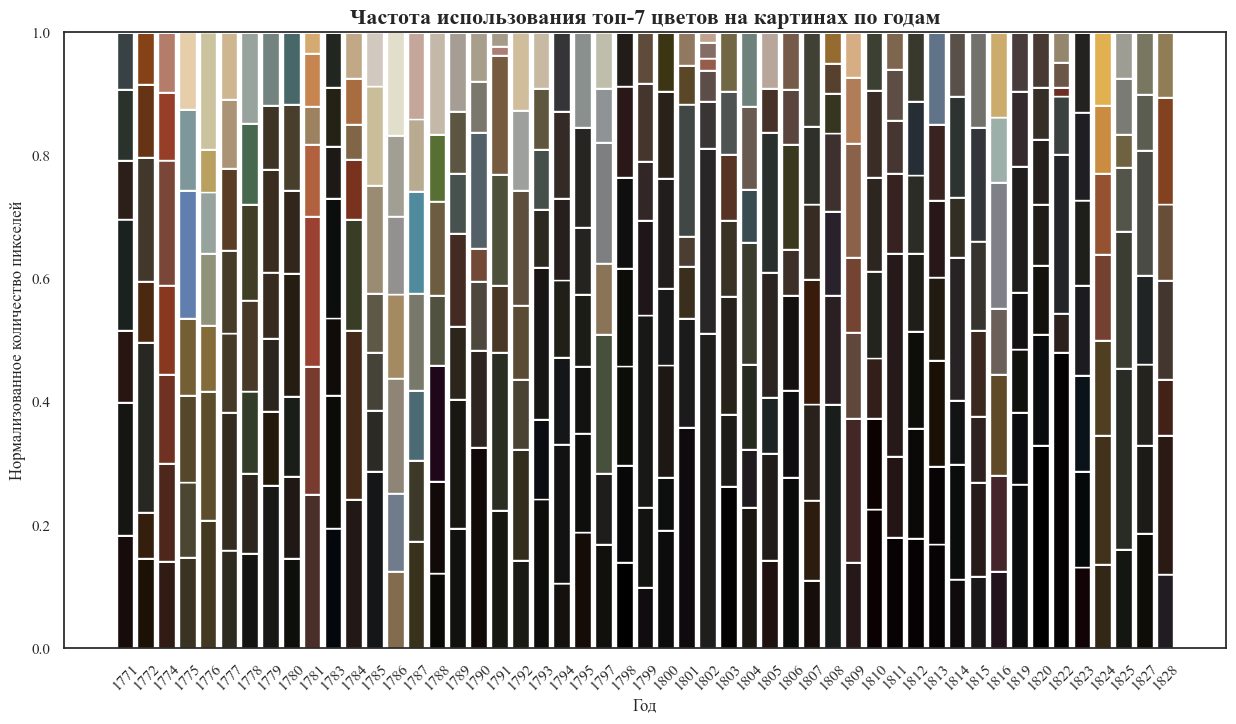

In [134]:
plot_color_distribution(colors_by_year_km, how='sorted', classifier='KMeans')

In [122]:
# colors_by_year_km

In [123]:
rows = []
for year, colors in colors_by_year_km.items():
    color_list = list(colors.items())[:7]  # Оставляем только 7 цветов
    row = [year]
    for i, ((r, g, b), count) in enumerate(color_list):
        row.extend([r, g, b, count])  # Добавляем R, G, B и Count
    rows.append(row)
    
columns = ['year']
for i in range(1, 8):  # 7 цветов
    columns.extend([f'R{i}', f'G{i}', f'B{i}', f'Count{i}'])

# Создаем DataFrame
df = pd.DataFrame(rows, columns=columns)
df.head()

,year,R1,G1,B1,Count1,R2,G2,B2,Count2,R3,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1938,201,200,183,4054,146,149,141,3406,39,...,97,1589,190,117,76,1460,99,56,54,1285
1,1895,59,61,58,7344,43,33,27,6505,212,...,54,4498,21,18,17,4462,49,119,166,4163
2,1902,37,36,39,7135,18,24,31,6956,23,...,171,4754,209,176,149,4731,22,32,38,4686
3,1893,15,8,10,7569,34,15,15,5083,33,...,70,4076,157,144,171,4014,63,61,45,3435
4,1888,38,35,32,3126,76,68,57,2851,160,...,41,2011,205,168,119,1766,202,151,80,1181


In [124]:
df_KMeans = pd.merge(df_KMeans, df, on='year', how='inner')
df_KMeans.head()

,year,"(36, 35, 39)","(76, 70, 60)","(197, 189, 178)","(135, 123, 95)","(100, 117, 145)","(153, 80, 50)","(198, 159, 84)",R1,G1,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1882,9503,3978,269,802,0,5,7,44,58,...,26,2584,49,42,35,2105,201,166,129,1593
1,1883,252,884,463,2527,0,189,68,165,129,...,117,2070,224,210,194,1390,57,43,45,662
2,1885,6388,3420,602,407,22,49,29,33,42,...,159,769,155,145,114,692,135,96,64,345
3,1886,5862,1731,254,948,10,126,30,30,25,...,70,1572,175,173,153,1112,103,93,78,1067
4,1888,2627,2598,22,990,1,502,1049,38,35,...,41,2011,205,168,119,1766,202,151,80,1181


In [125]:
df_counts['year'] = df_counts['year'].astype(int)
df_KMeans = pd.merge(df_KMeans, df_counts, on='year', how='inner')

In [126]:
df_KMeans.head()

,year,"(36, 35, 39)","(76, 70, 60)","(197, 189, 178)","(135, 123, 95)","(100, 117, 145)","(153, 80, 50)","(198, 159, 84)",R1,G1,...,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7,count
0,1882,9503,3978,269,802,0,5,7,44,58,...,2584,49,42,35,2105,201,166,129,1593,2
1,1883,252,884,463,2527,0,189,68,165,129,...,2070,224,210,194,1390,57,43,45,662,1
2,1885,6388,3420,602,407,22,49,29,33,42,...,769,155,145,114,692,135,96,64,345,1
3,1886,5862,1731,254,948,10,126,30,30,25,...,1572,175,173,153,1112,103,93,78,1067,1
4,1888,2627,2598,22,990,1,502,1049,38,35,...,2011,205,168,119,1766,202,151,80,1181,1


In [127]:
df_KMeans.to_csv('data_KMeans.csv', index=False)

#### BayesianGaussianMixture:

In [135]:
colors_by_year_bgm = get_colors_by_year(folder_path, classifier='GMM')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initializa

{1799: {(23, 23, 22): 10042, (74, 61, 50): 6062, (42, 31, 33): 4426, (36, 26, 29): 4257, (15, 17, 16): 4164, (83, 52, 41): 3899, (111, 133, 127): 3855}, 1775: {(98, 130, 177): 5230, (104, 85, 49): 5163, (84, 79, 54): 4727, (86, 77, 42): 4408, (63, 55, 34): 4378, (131, 156, 159): 3866, (67, 53, 22): 3478}, 1812: {(46, 47, 39): 8914, (37, 42, 52): 8831, (3, 1, 1): 6729, (10, 10, 8): 6370, (90, 97, 90): 6255, (31, 29, 25): 6210, (6, 6, 3): 6147}, 1787: {(86, 80, 47): 5624, (79, 138, 156): 5436, (100, 69, 65): 4449, (70, 60, 40): 4446, (124, 127, 116): 4387, (198, 169, 156): 3815, (77, 108, 118): 3706}, 1814: {(39, 36, 37): 9608, (84, 75, 71): 8256, (9, 11, 11): 7304, (88, 71, 67): 6349, (39, 48, 47): 5161, (86, 65, 51): 4992, (83, 58, 51): 4910}, 1795: {(19, 10, 6): 6472, (37, 37, 33): 6049, (138, 144, 143): 5985, (80, 85, 77): 5336, (9, 11, 8): 4679, (251, 230, 197): 4641, (98, 96, 70): 4562}, 1820: {(0, 0, 0): 12237, (8, 9, 10): 6025, (41, 38, 34): 4798, (22, 19, 14): 4260, (36, 33, 28)

[1771, 1772, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1819, 1820, 1822, 1823, 1824, 1825, 1827, 1828]


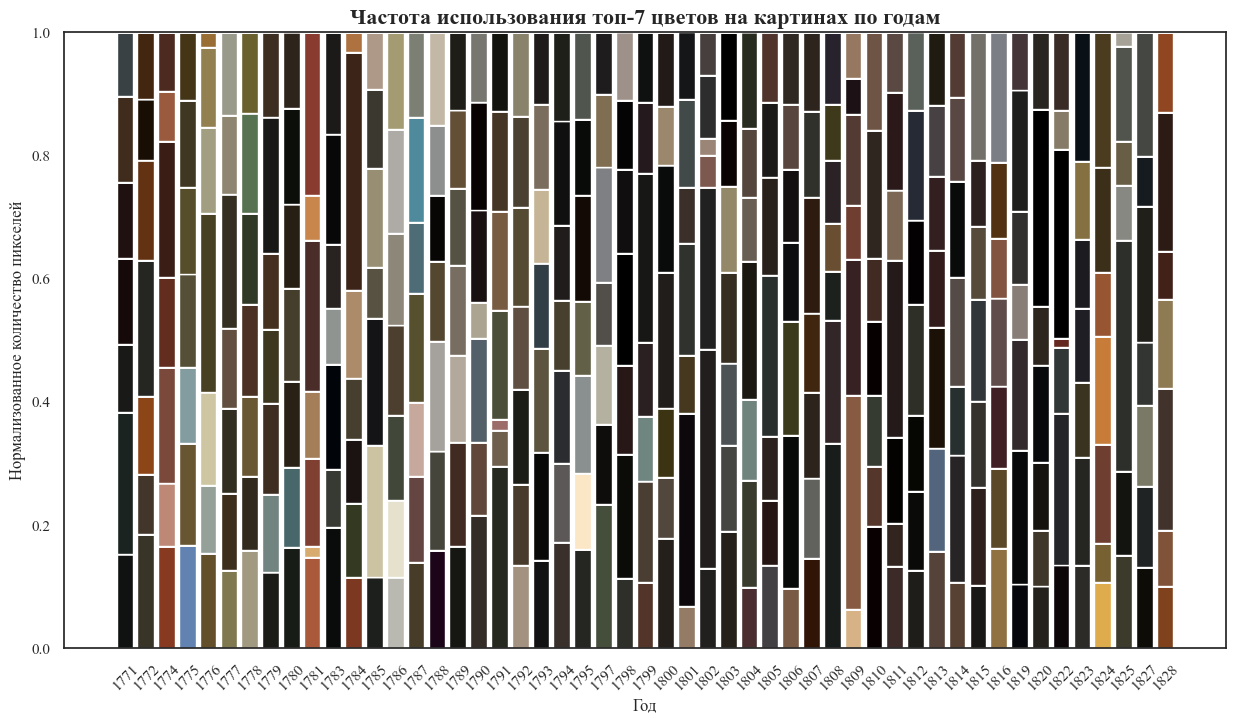

In [136]:
plot_color_distribution(colors_by_year_bgm, classifier='GMM', how='not_sorted')

Отсортировано по яркости:

[1771, 1772, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1819, 1820, 1822, 1823, 1824, 1825, 1827, 1828]


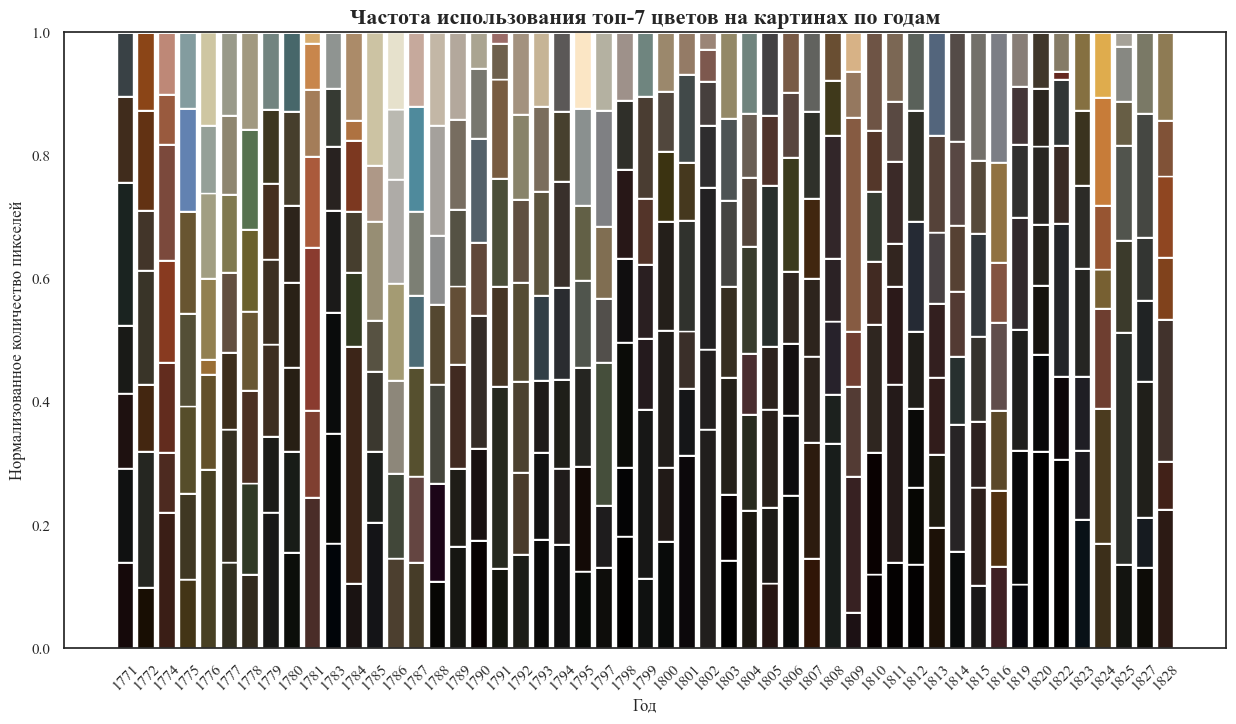

In [137]:
plot_color_distribution(colors_by_year_bgm, how='sorted', classifier='GMM')

In [131]:
rows = []
for year, colors in colors_by_year_bgm.items():
    color_list = list(colors.items())[:7]  # Оставляем только 7 цветов
    row = [year]
    for i, ((r, g, b), count) in enumerate(color_list):
        row.extend([r, g, b, count])  # Добавляем R, G, B и Count
    rows.append(row)
    
columns = ['year']
for i in range(1, 8):  # 7 цветов
    columns.extend([f'R{i}', f'G{i}', f'B{i}', f'Count{i}'])

# Создаем DataFrame
df = pd.DataFrame(rows, columns=columns)
df.head()

,year,R1,G1,B1,Count1,R2,G2,B2,Count2,R3,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1938,187,193,181,4209,134,131,127,3502,34,...,55,1773,227,202,107,1413,84,119,115,1327
1,1895,58,60,58,5745,212,121,72,5558,48,...,21,4262,77,97,131,4215,67,61,54,3840
2,1902,19,27,35,6699,34,34,37,5286,179,...,45,4358,211,174,147,4336,215,194,187,4202
3,1893,116,98,84,5873,36,15,14,5363,9,...,35,4438,168,154,178,4128,165,113,77,4076
4,1888,65,61,53,3415,113,96,66,3336,134,...,34,2058,178,144,87,1979,143,83,37,767


In [132]:
df_BGM = pd.merge(df_BGM, df, on='year', how='inner')
df_BGM.head()

,year,"(126, 124, 113)","(51, 50, 49)","(125, 78, 53)","(199, 164, 114)","(201, 195, 184)","(21, 22, 24)","(55, 73, 93)",R1,G1,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1882,471,11074,229,1465,303,11192,1388,41,56,...,22,2946,195,161,125,2053,93,81,74,1882
1,1883,814,321,1403,1988,492,135,17,178,147,...,198,1148,195,148,122,576,56,43,46,521
2,1885,577,6982,126,103,561,2532,481,66,72,...,176,1061,137,122,99,912,84,59,43,350
3,1886,307,5684,612,469,154,4721,477,44,50,...,128,2013,146,161,147,532,121,77,57,299
4,1888,333,2897,1588,1141,20,1710,20,65,61,...,34,2058,178,144,87,1979,143,83,37,767


In [133]:
df_counts['year'] = df_counts['year'].astype(int)
df_BGM = pd.merge(df_BGM, df_counts, on='year', how='inner')

In [134]:
df_BGM.head()

,year,"(126, 124, 113)","(51, 50, 49)","(125, 78, 53)","(199, 164, 114)","(201, 195, 184)","(21, 22, 24)","(55, 73, 93)",R1,G1,...,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7,count
0,1882,471,11074,229,1465,303,11192,1388,41,56,...,2946,195,161,125,2053,93,81,74,1882,2
1,1883,814,321,1403,1988,492,135,17,178,147,...,1148,195,148,122,576,56,43,46,521,1
2,1885,577,6982,126,103,561,2532,481,66,72,...,1061,137,122,99,912,84,59,43,350,1
3,1886,307,5684,612,469,154,4721,477,44,50,...,2013,146,161,147,532,121,77,57,299,1
4,1888,333,2897,1588,1141,20,1710,20,65,61,...,2058,178,144,87,1979,143,83,37,767,1


In [135]:
df_BGM.to_csv('data_BGM.csv', index=False)